# **Document Embedding with Doc2Vec**

The goal of this project is to embedd documents using Doc2Vec and cluster the embeddings. We try both the Distributed Bag of Words and the Distributed Memory approach. The dataset consist of news articles and associated categories. To evaluate the embeddings, several cluster metrics and the cosine similarity are measured.

#**Preprocessing Steps**



This section outlines the steps that occur prior to the generation of embeddings. These steps are necessary to ensure the successful generation of the embeddings.

## **Install Required Packages**


In [ ]:
#Gensim: An open-source library for unsupervised topic modelling and natural language processing, in this library are the tools and models we need for document embedding, the version is important so all functions from gensim are working fine
!pip install gensim==4.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.2
    Uninstalling gensim-4.3.2:
      Successfully uninstalled gensim-4.3.2


##**Import Statements**

In [ ]:
#Imports the pandas library for data manipulation and analysis
import pandas as pd
#Library for numerical computations
import numpy as np
#Import the PyTorch library, which is used for tensor computations and deep learning
import torch
#Initializes a WordNetLemmatizer for reducing words to their base forms
from nltk.stem import WordNetLemmatizer
#Initializes a PorterStemmer which reduces words to their root forms
from nltk.stem import PorterStemmer
#Imports the Natural Language Toolkit (NLTK) for text processing
import nltk
#Imports a list of stopwords for text processing
from nltk.corpus import stopwords
#Imports the regular expression module for string pattern matching.
import re
#Imports a module for vreating dictionaries with default values
from collections import defaultdict
#Imports the time function for time related operations
from time import time
#Imports the metrics module from scikit-learn library for evaluating machine learning models
from sklearn import metrics
#Import the BERT model and tokenizer from the Hugging Face Transformers library
from transformers import BertModel, BertTokenizer
#Imports TSNE class for dimensionality reduction
from sklearn.manifold import TSNE
#from collections import OrderedDict
#Imports the pyplot module for creating visualizations
import matplotlib.pyplot as plt
#Imports the seaborn library for statistical data visualization
import seaborn as sns
#Imports KMeans class for K-means clustering
from sklearn.cluster import KMeans
#Imports the cosine_similarity for computing cosine similarity between pairs of samples
from sklearn.metrics.pairwise import cosine_similarity
#Imports Counter class for counting hashable objects
from collections import Counter
#Imports silhouette_samples and silhouette_score for measuring the quality of clustering
from sklearn.metrics import silhouette_samples, silhouette_score
#Imports the cm module for handling colormaps
import matplotlib.cm as cm
#Imports the drive module for accessing Google Drive files in Google Colab environment.
from google.colab import drive
# Import the LabelEncoder class to convert categorical variables into numeric values
from sklearn.preprocessing import LabelEncoder
#A built-in package which allows the system to run multiple processes simultaneously
import multiprocessing
#Represents a document along with a tag, input document format for Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#Doc2vec: create a vectorised representation of a group of words taken collectively as a single unit
from gensim.models import doc2vec
#Library for implementing several loss, score, and utility functions to measure classification performance
import sklearn.metrics as sm
#Import the gensim library for topic modeling and natural language processing tasks
import gensim
#Import the word_tokenize function from NLTK for tokenizing text into words
from nltk.tokenize import word_tokenize
#Import the PCA class for principal component analysis, a technique for dimensionality reduction
from sklearn.decomposition import PCA

## **Download Statements**

In [ ]:
#Downloads the WordNet dataset for the NLTK library for using certain features like lemmatization
nltk.download('wordnet')
#Downloads the stopwords dataset for the NLTK library, which contains common words
nltk.download('stopwords')
#Download the NLTK tokenizer data for word_tokenize function
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Data Preprocessing**

###Dataset One

The dataset consists of 252 different news articles and eight categories. The dataset is stored in the path variable.


In [ ]:
#Mounts the Google Drive at ("/content/drive") in the Google Colab enviornment
drive.mount("/content/drive")
path = "/content/drive/MyDrive/Implementation/Dataset/NewsTwo.csv"

Mounted at /content/drive


In [ ]:
#Read a CSV file into a pandas DataFrame object using the latin1 encoding
news_df = pd.read_csv(path,encoding='latin1')

Preprocessing consists of several steps. First, the data is converted into lowercase and stored in a new DataFrame object.Then the functions for lemmatization, stemming, removal of stop words and removal of special characters are implemented

In [ ]:
#Save the original 'News' column for comparison later
news_df['Original_News'] = news_df['News']
news_df['Preprocessed_News'] = news_df['News']

#Convert to lowercase
news_df['Preprocessed_News'] = news_df['Preprocessed_News'].str.lower()

#Setting the language setting for the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

All preprocessing steps are combined in one function. In some cases it is better to use lemmatization and stemming. In some other cases it is not suitable. In this case, it is better to use these features

In [ ]:
#Text pre-processing function
def preprocess_text(text):
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text) #You can choose whether to apply lemmatization
    text = stem_text(text)  #You can choose whether to apply stemming
    return text

Now the preprocessing steps are applied to the dataset

In [ ]:
#Apply preprocessing to the documents
news_df['Preprocessed_News'] = news_df['Preprocessed_News'].apply(preprocess_text)

#Check for missing values ​​and handle them
if news_df.isnull().values.any():
    news_df.dropna(inplace=True)

#Extract the text data and associated categories from the filtered DataFrame
text_data = news_df['Preprocessed_News']
labels = news_df['Category']
print(f"{len(text_data)} documents ")

#Calculate unique labels and their counts and store the number of categories in "true_k"
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

#Display the total number of documents an categories
print(f"{len(news_df)} documents - {true_k} categories")

#Extract the text data and associated categories from the filtered DataFrame
text_data = news_df['Preprocessed_News']

252 documents 
252 documents - 8 categories


Compare the news article before and after preprocessing

In [ ]:
#Create a new DataFrame to compare original and preprocessed news articles
comparison_df = news_df[['Original_News', 'Preprocessed_News']]
comparison_df.head(10)

,Original_News,Preprocessed_News
0,The IMF now expects China's economy to grow by...,imf expect china economi grow year higher prev...
1,Manufacturing activity in the Eurozone has dec...,manufactur activ eurozon declin retail sale fa...
2,Continued disruptions in the global supply cha...,continu disrupt global suppli chain includ rec...
3,Concerns about food security remain high due t...,concern food secur remain high due war ukrain ...
4,"While some central banks, like the US Federal ...",central bank like u feder reserv continu rais ...
5,Bangladeshi workers abroad continue to send st...,bangladeshi worker abroad continu send strong ...
6,The Centre for Economics and Business Research...,centr econom busi research cebr predict bangla...
7,Bangladesh has maintained macroeconomic stabil...,bangladesh maintain macroeconom stabil despit ...
8,Government investments in infrastructure proje...,govern invest infrastructur project like road ...
9,"he US unemployment rate has dropped to 3.5%, i...",u unemploy rate drop lowest level decad reflec...


The code prepares data for training a model by creating a list of tagged documents. Each document in text_data is tokenized into words and then paired with a unique tag represented by its index in text_data. This tagging process helps in associating each document's words with its specific identifier for training a Doc2Vec model.

In [ ]:
tagged_data = [TaggedDocument(words = word_tokenize(doc),tags=[str(i)]) for i,doc in enumerate(text_data)]

In [ ]:
tagged_data[:2]

[TaggedDocument(words=['imf', 'expect', 'china', 'economi', 'grow', 'year', 'higher', 'previou', 'estim', 'reflect', 'china', 'shift', 'away', 'zerocovid', 'polici', 'increas', 'govern', 'stimulu'], tags=['0']),
 TaggedDocument(words=['manufactur', 'activ', 'eurozon', 'declin', 'retail', 'sale', 'fallen', 'rais', 'concern', 'possibl', 'recess', 'come', 'month'], tags=['1'])]

### Dataset Two

The dataset consists of 50000 different news articles and ten categories.

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CSV-Datei laden
df_two = pd.read_csv("/content/drive/MyDrive/Implementation/Dataset/NewsCategorizer.csv")

news_two_df = df_two.drop(['headline','links','keywords'], axis = 1)

Preprocessing consists of several steps. First, the data is converted into lowercase and stored in a new DataFrame object.Then the functions for lemmatization, stemming, removal of stop words and removal of special characters are implemented

In [ ]:
#Convert to lowercase
news_two_df['short_description'] = news_two_df['short_description'].str.lower()

#Setting the language setting for the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)


All preprocessing steps are combined in one function. In some cases it is better to use lemmatization and stemming. In some other cases it is not suitable.In this case, it is better to use these features

In [ ]:
#Text pre-processing function
def preprocess_text(text):
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text) #You can choose whether to apply lemmatization
    text = stem_text(text)  #You can choose whether to apply stemming
    return text

Now the preprocessing steps are applied to the dataset

In [ ]:
#Apply preprocessing to the documents
news_two_df['short_description'] = news_two_df['short_description'].apply(preprocess_text)

#Check for missing values ​​and handle them
if news_two_df.isnull().values.any():
    news_two_df.dropna(inplace=True)

#Extract the text data and associated categories from the filtered DataFrame
text_data_two = news_two_df['short_description']
labels_two = news_two_df['category']
print(f"{len(text_data_two)} documents ")

#Calculate unique labels and their counts and store the number of categories in "true_k"
unique_labels_two, category_sizes_two = np.unique(labels_two, return_counts=True)
true_k_two = unique_labels_two.shape[0]

#Display the total number of documents an categories
print(f"{len(news_two_df)} documents - {true_k_two} categories")

50000 documents 
50000 documents - 10 categories


Compare the news article before and after preprocessing

In [ ]:
#Save the original 'News' column for comparison later
news_two_df['Original_News'] = df_two['short_description']
news_two_df['Preprocessed_News'] = news_two_df['short_description']
news_two_df['News'] = news_two_df['short_description']

In [ ]:
news_two_df['Category'] = news_two_df['category']

In [ ]:
#Create a new DataFrame to compare original and preprocessed news articles
comparison_df_two = news_two_df[['Original_News', 'Preprocessed_News']]
comparison_df_two.head(10)

,Original_News,Preprocessed_News
0,Resting is part of training. I've confirmed wh...,rest part train ive confirm sort alreadi knew ...
1,Think of talking to yourself as a tool to coac...,think talk tool coach challeng narrat experi c...
2,The clock is ticking for the United States to ...,clock tick unit state find cure team work stud...
3,"If you want to be busy, keep trying to be perf...",want busi keep tri perfect want happi focu mak...
4,"First, the bad news: Soda bread, corned beef a...",first bad news soda bread corn beef beer highl...
5,"By Carey Moss for YouBeauty.com Love rom-coms,...",carey moss youbeautycom love romcom love song ...
6,The nation in general scored a 66.2 in 2011 on...,nation gener score scale littl bit score
7,It's also worth remembering that if the water ...,also worth rememb water seawe come contamin sa...
8,"If you look at our culture's eating behavior, ...",look cultur eat behavior certainli look like a...
9,"François-Marie Arouet, 18th century French aut...",franoismari arouet th centuri french author ic...


The code prepares data for training a model by creating a list of tagged documents. Each document in text_data is tokenized into words and then paired with a unique tag represented by its index in text_data. This tagging process helps in associating each document's words with its specific identifier for training a Doc2Vec model.

In [ ]:
tagged_data_two = [TaggedDocument(words = word_tokenize(doc),tags=[str(i)]) for i,doc in enumerate(text_data_two)]

In [ ]:
tagged_data_two[:2]

[TaggedDocument(words=['rest', 'part', 'train', 'ive', 'confirm', 'sort', 'alreadi', 'knew', 'im', 'built', 'run', 'streak', 'im', 'built', 'hard', 'workout', 'three', 'five', 'day', 'week', 'lot', 'cross', 'train', 'physic', 'therapi', 'foam', 'roll', 'ive', 'also', 'confirm', 'im', 'stubborn'], tags=['0']),
 TaggedDocument(words=['think', 'talk', 'tool', 'coach', 'challeng', 'narrat', 'experi', 'case', 'treat', 'respect', 'may', 'find', 'enjoy', 'compani'], tags=['1'])]

### Dataset Three

The dataset consists of around 100000 different news articles and eight categories.

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CSV-Datei laden
df_three = pd.read_csv("/content/drive/MyDrive/Implementation/Dataset/NewNews.csv",delimiter=";")

news_three_df = df_three.drop(['link','domain','published_date','lang'], axis = 1)

Preprocessing consists of several steps. First, the data is converted into lowercase and stored in a new DataFrame object.Then the functions for lemmatization, stemming, removal of stop words and removal of special characters are implemented

In [ ]:
#Convert to lowercase
news_three_df['title'] = news_three_df['title'].str.lower()

#news_three_df = news_three_df.groupby('topic').apply(lambda x: x.sample(min(len(x), 1000))).reset_index(drop=True)

#Setting the language setting for the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)


All preprocessing steps are combined in one function. In some cases it is better to use lemmatization and stemming. In some other cases it is not suitable. In this case, it is better to use these features

In [ ]:
#Text pre-processing function
def preprocess_text(text):
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text) #You can choose whether to apply lemmatization
    text = stem_text(text)  #You can choose whether to apply stemming
    return text

Now the preprocessing steps are applied to the dataset

In [ ]:
#Apply preprocessing to the documents
news_three_df['title'] = news_three_df['title'].apply(preprocess_text)

#Check for missing values ​​and handle them
if news_three_df.isnull().values.any():
    news_three_df.dropna(inplace=True)

#Extract the text data and associated categories from the filtered DataFrame
text_data_three = news_three_df['title']
labels_three = news_three_df['topic']
print(f"{len(text_data_three)} documents ")

#Calculate unique labels and their counts and store the number of categories in "true_k"
unique_labels_three, category_sizes_three = np.unique(labels_three, return_counts=True)
true_k_three = unique_labels_three.shape[0]

#Display the total number of documents an categories
print(f"{len(news_three_df)} documents - {true_k_three} categories")

108774 documents 
108774 documents - 8 categories


Compare the news article before and after preprocessing

In [ ]:
#Save the original 'News' column for comparison later
news_three_df['Original_News'] = df_three['title']
news_three_df['Preprocessed_News'] = news_three_df['title']
news_three_df['News'] = news_three_df['title']

In [ ]:
news_three_df['Category'] = news_three_df['topic']

In [ ]:
#Create a new DataFrame to compare original and preprocessed news articles
comparison_df_three = news_three_df[['Original_News', 'Preprocessed_News']]
comparison_df_three.head(10)

,Original_News,Preprocessed_News
0,A closer look at water-splitting's solar fuel ...,closer look watersplit solar fuel potenti
1,An irresistible scent makes locusts swarm stud...,irresist scent make locust swarm studi find
2,Artificial intelligence warning: AI will know ...,artifici intellig warn ai know u better know
3,Glaciers Could Have Sculpted Mars Valleys: Study,glacier could sculpt mar valley studi
4,Perseid meteor shower 2020: What time and how ...,perseid meteor shower time see huge bright fir...
5,NASA Releases In-Depth Map of Beirut Explosion...,nasa releas indepth map beirut explos damag
6,"SpaceX, NASA Demo-2 Rocket Launch Set for Satu...",spacex nasa demo rocket launch set saturday watch
7,Orbital space tourism set for rebirth in 2021,orbit space tourism set rebirth
8,Greenland's melting ice sheet has 'passed the ...,greenland melt ice sheet pass point return
9,NASA invites engineering students to help harv...,nasa invit engin student help harvest water ma...


The code prepares data for training a model by creating a list of tagged documents. Each document in text_data is tokenized into words and then paired with a unique tag represented by its index in text_data. This tagging process helps in associating each document's words with its specific identifier for training a Doc2Vec model.

In [ ]:
tagged_data_three = [TaggedDocument(words = word_tokenize(doc),tags=[str(i)]) for i,doc in enumerate(text_data_three)]

In [ ]:
tagged_data_three[:2]

[TaggedDocument(words=['closer', 'look', 'watersplit', 'solar', 'fuel', 'potenti'], tags=['0']),
 TaggedDocument(words=['irresist', 'scent', 'make', 'locust', 'swarm', 'studi', 'find'], tags=['1'])]

# **Doc2Vec on first Dataset**

Doc2Vec models come in two primary variants: Distributed Memory (DM) and Distributed Bag of Words (DBOW). The DM model, proposed by Mikolov et al., extends Word2Vec's Continuous Bag of Words (CBOW) by incorporating both word context and document context to predict the next word in a sequence. In contrast, the DBOW model focuses solely on predicting the next word based on the document index, disregarding surrounding word context altogether.

##**Distributed Bag of Words**

### **Doc2Vec**

This code initializes a Doc2Vec model using the following hyperparameters.


In [ ]:
#Constructing the model with the best hyperparameters for Random Forest
model = Doc2Vec(dm = 0, #Indicates the Distributed Bag of Words (DBOW) mode for the Doc2Vec model.
                 dm_mean = 1, #Specifies to use the mean of context word vectors in DBOW mode
                 vector_size = 200, #Sets the dimensionality of the feature vectors to 200.
                 min_count = 5, #Ignores all words with a total frequency lower than 2 during the vocabulary building process.
                 epochs = 10, #Number of iterations (epochs) over the corpus during training
                 window = 5, #Maximum distance between the predicted word and context words within a sentence.
                 alpha = 0.025, #Initial learning rate for training the model.
                 min_alpha = 0.0001, #Minimum learning rate. Learning rate will linearly drop to this value as training progresses.
                 workers = 1, #Number of worker threads to use for training the model
                 seed = 1) #Seed for reproducibility of resul ts

 It builds the vocabulary using the tagged documents.

In [ ]:
model.build_vocab(tagged_data)

It trains the model on the tagged data for the specified number of epochs.

In [ ]:
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

Here we tokenize each document in text data, then use the Doc2Vec model  to infer embeddings for each document based on its tokenized words. The resulting document embeddings are stored as a NumPy array, capturing semantic meanings learned by the model.

In [ ]:
document_t = [word_tokenize(doc) for doc in text_data]

In [ ]:
doc_embeddings = [model.infer_vector(doc) for doc in document_t]

In [ ]:
np_document_embeddings = np.array(doc_embeddings)

### **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans = KMeans(
    n_clusters=true_k,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(np_document_embeddings)



Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, t-SNE (t-Distributed Stochastic Neighbor Embedding) is used

In [ ]:
#Reduce dimensionality of embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42,init='random')
embeddings_2d = tsne.fit_transform(np_document_embeddings)

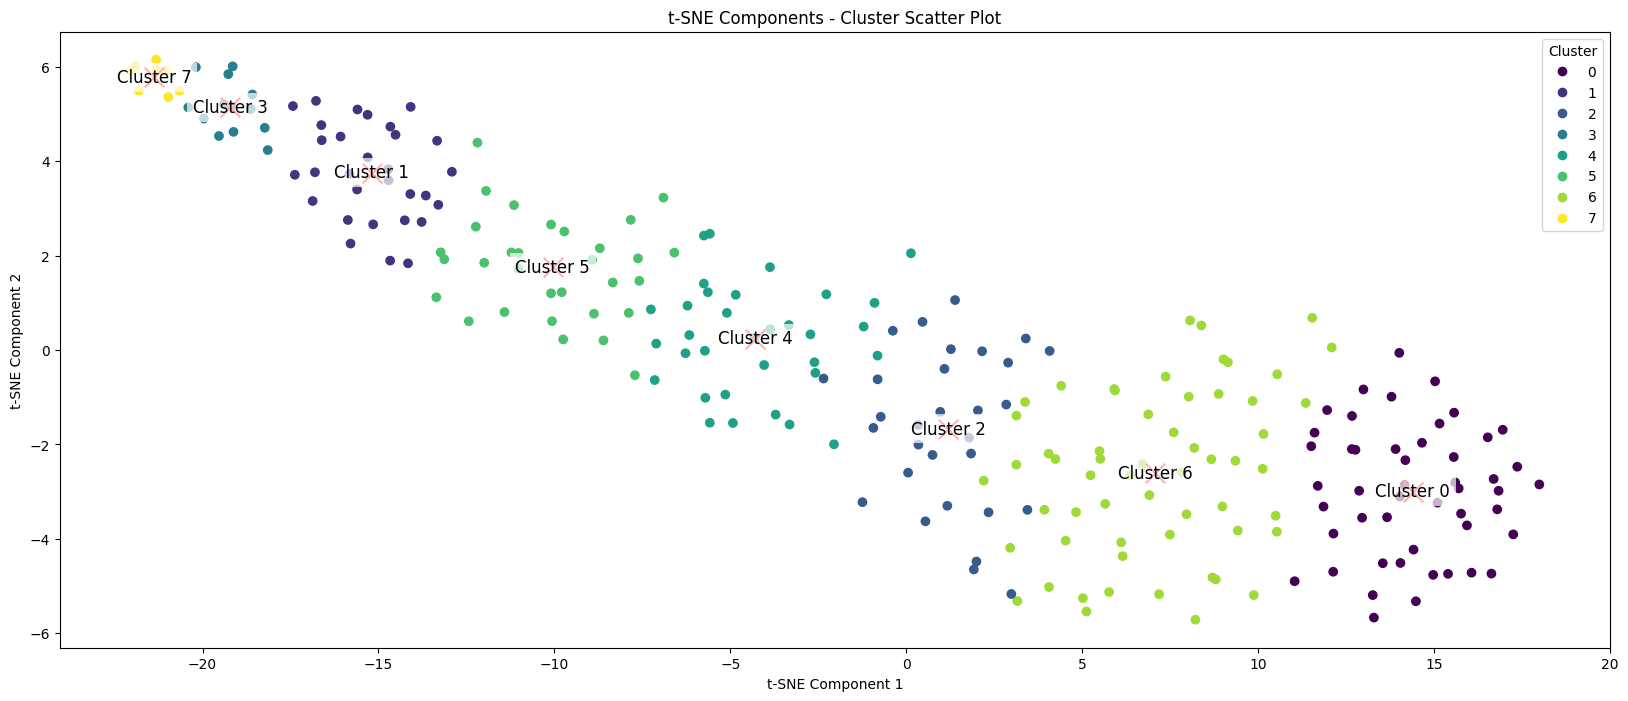

True number of documents in each category according to the class labels: [27 35 39 36 27 32 24 32]
Number of elements assigned to each cluster: [49 30 30 13 33 31 58  8]


In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_doc, cluster_sizes_doc = np.unique(kmeans.labels_, return_counts=True)

#Visualize the clusters using the t-SNE reduced data
plt.figure(figsize=(20, 8))
cluster_labels = kmeans.labels_

scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k):
    plt.text(embeddings_2d[cluster_labels == label, 0].mean(), embeddings_2d[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d[cluster_labels == label, 0].mean(), embeddings_2d[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_doc}")


### **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters

In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

Applies the fit_and_evaluate function and visualizes it

clustering done in 1.24 ± 0.25 s 
Homogeneity: 0.127 ± 0.006
Completeness: 0.136 ± 0.004
V-measure: 0.131 ± 0.005
Adjusted Rand-Index: 0.047 ± 0.003
Silhouette Coefficient: 0.056 ± 0.005


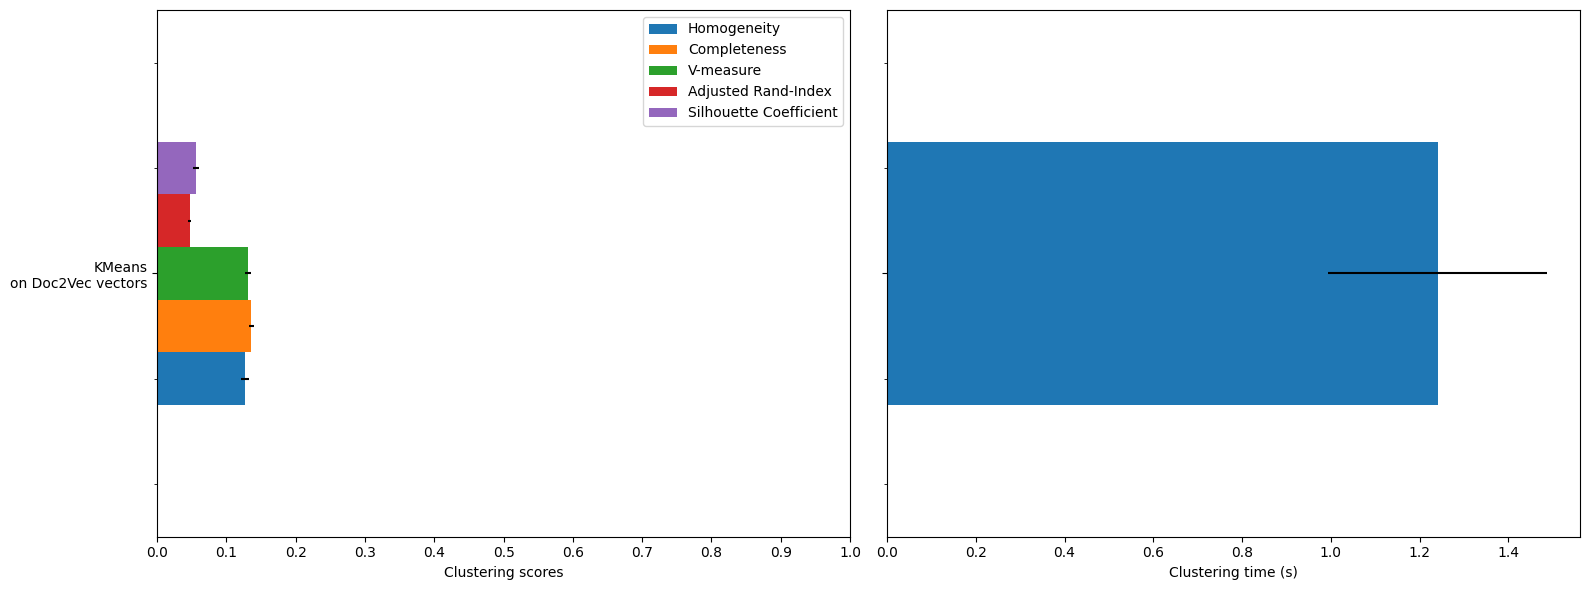

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans, np_document_embeddings, name="KMeans\non Doc2Vec vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

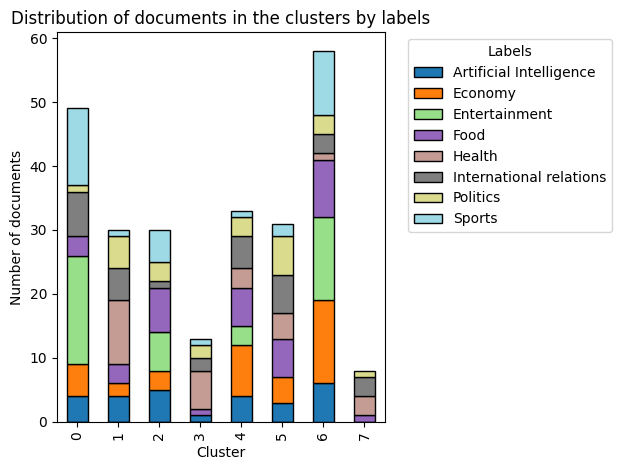

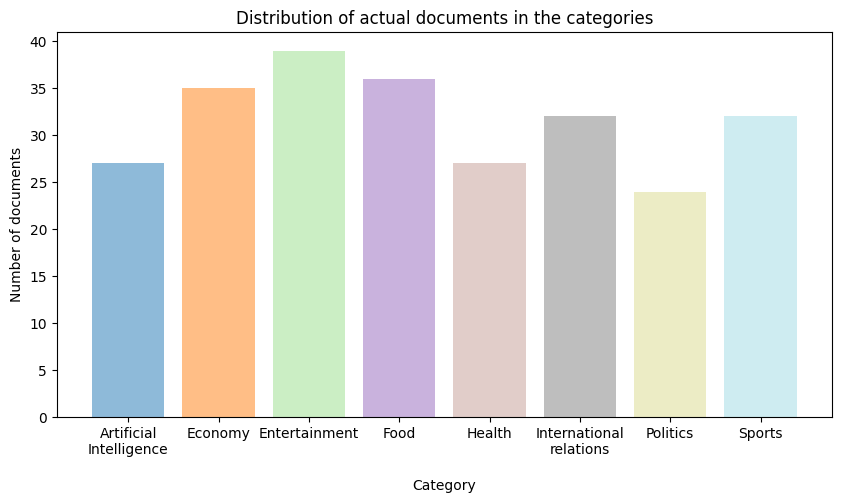


Distribution of documents in the clusters according to labels:
true_label  Artificial Intelligence   Economy  Entertainment  Food  Health  \
cluster                                                                      
0                                  4        5             17     3       0   
1                                  4        2              0     3      10   
2                                  5        3              6     7       0   
3                                  1        0              0     1       6   
4                                  4        8              3     6       3   
5                                  3        4              0     6       4   
6                                  6       13             13     9       1   
7                                  0        0              0     1       3   

true_label  International relations  Politics  Sports  
cluster                                                
0                                 7        

In [ ]:
x_labels = news_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes)), category_sizes, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_doc):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_df[news_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the DBOW vectors of the documents in the current category.
        category_doc = np_document_embeddings[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_doc)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for Economy: 0.6499385545233719
Average Cosine Similarity for Health: 0.9060207269130609
Average Cosine Similarity for Sports: 0.5599043446202432
Average Cosine Similarity for Entertainment: 0.42991434321229755
Average Cosine Similarity for Politics: 0.7977385590041893
Average Cosine Similarity for International relations: 0.7195515786447833
Average Cosine Similarity for Food: 0.7120922754681299
Average Cosine Similarity for Artificial Intelligence : 0.6815399430755876


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_df[news_df['Category'] == category1].index
    category1_vector = np_document_embeddings[indices1]

    #Extract the documents in the second category
    indices2 = news_df[news_df['Category'] == category2].index
    category2_vector = np_document_embeddings[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between Economy and Health: 0.7669116854667664
Average Cosine Similarity between Sports and Entertainment: 0.49324819445610046
Average Cosine Similarity between Politics and International relations: 0.7579362392425537
Average Cosine Similarity between Food and Artificial Intelligence : 0.6966263651847839


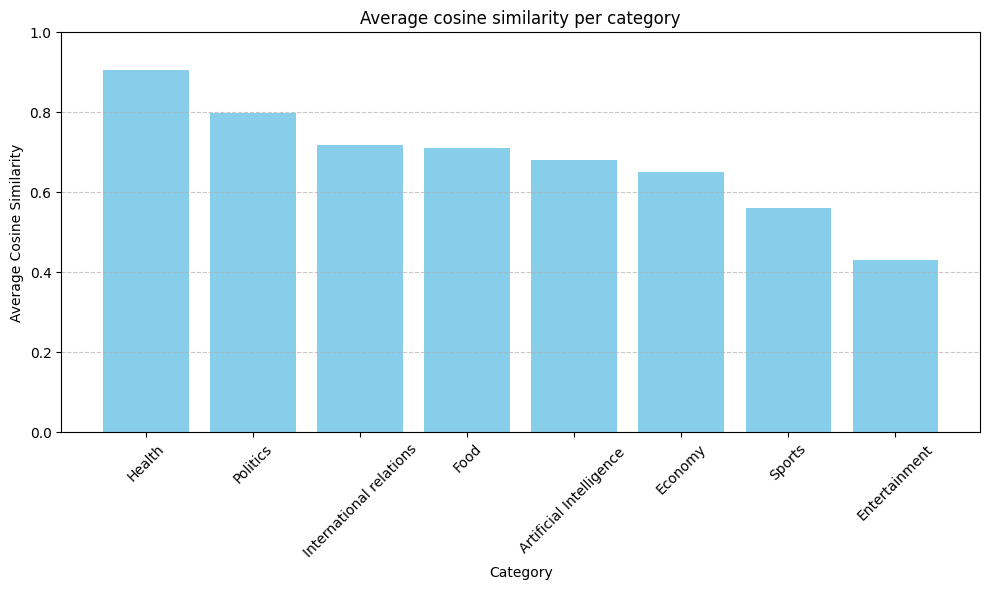

In [ ]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, np_document_embeddings)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

Here we create a heatmap which visually represents the top categories for each cluster


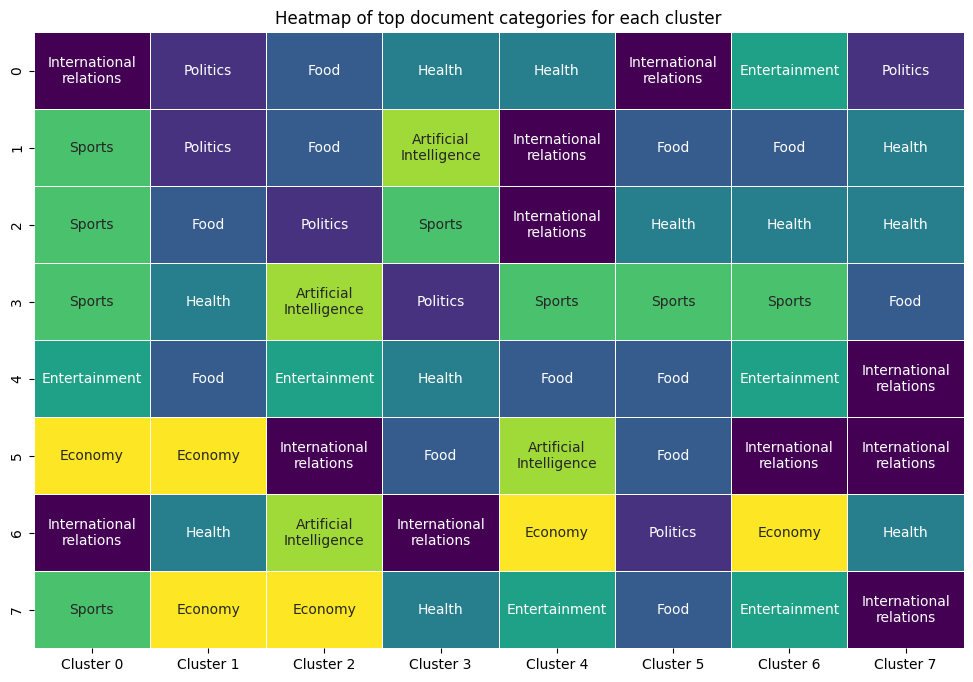

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)


#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k)])
heatmap_df = heatmap_df.T  # Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()

##**Distributed Memory**

### **Doc2Vec**

This code initializes a Doc2Vec model using the following hyperparameters.


In [ ]:
#Constructing the model with the best hyperparameters for Random Forest
model_one = Doc2Vec(dm = 1, #Indicates the Distributed Memory mode for the Doc2Vec model.
                 dm_mean = 1, #Specifies to use the mean of context word vectors in DBOW mode
                 vector_size = 200, #Sets the dimensionality of the feature vectors to 200.
                 min_count = 5, #Ignores all words with a total frequency lower than 2 during the vocabulary building process.
                 epochs = 10, #Number of iterations (epochs) over the corpus during training
                 window = 5, #Maximum distance between the predicted word and context words within a sentence.
                 alpha = 0.025, #Initial learning rate for training the model.
                 min_alpha = 0.0001, #Minimum learning rate. Learning rate will linearly drop to this value as training progresses.
                 workers = 1, #Number of worker threads to use for training the model
                 seed = 1) #Seed for reproducibility of results

 It builds the vocabulary using the tagged documents.

In [ ]:
model_one.build_vocab(tagged_data)

It trains the model on the tagged data for the specified number of epochs.

In [ ]:
model_one.train(tagged_data, total_examples=model_one.corpus_count, epochs=model_one.epochs)

Here we tokenize each document in text data, then use the Doc2Vec model  to infer embeddings for each document based on its tokenized words. The resulting document embeddings are stored as a NumPy array, capturing semantic meanings learned by the model.

In [ ]:
document_t_one = [word_tokenize(doc) for doc in text_data]

In [ ]:
doc_embeddings_one = [model_one.infer_vector(doc) for doc in document_t]

In [ ]:
np_document_embeddings_one = np.array(doc_embeddings_one)

### **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans = KMeans(
    n_clusters=true_k,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(np_document_embeddings_one)



Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, t-SNE (t-Distributed Stochastic Neighbor Embedding) is used

In [ ]:
#Reduce dimensionality of embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42,init='random')
embeddings_2d = tsne.fit_transform(np_document_embeddings_one)

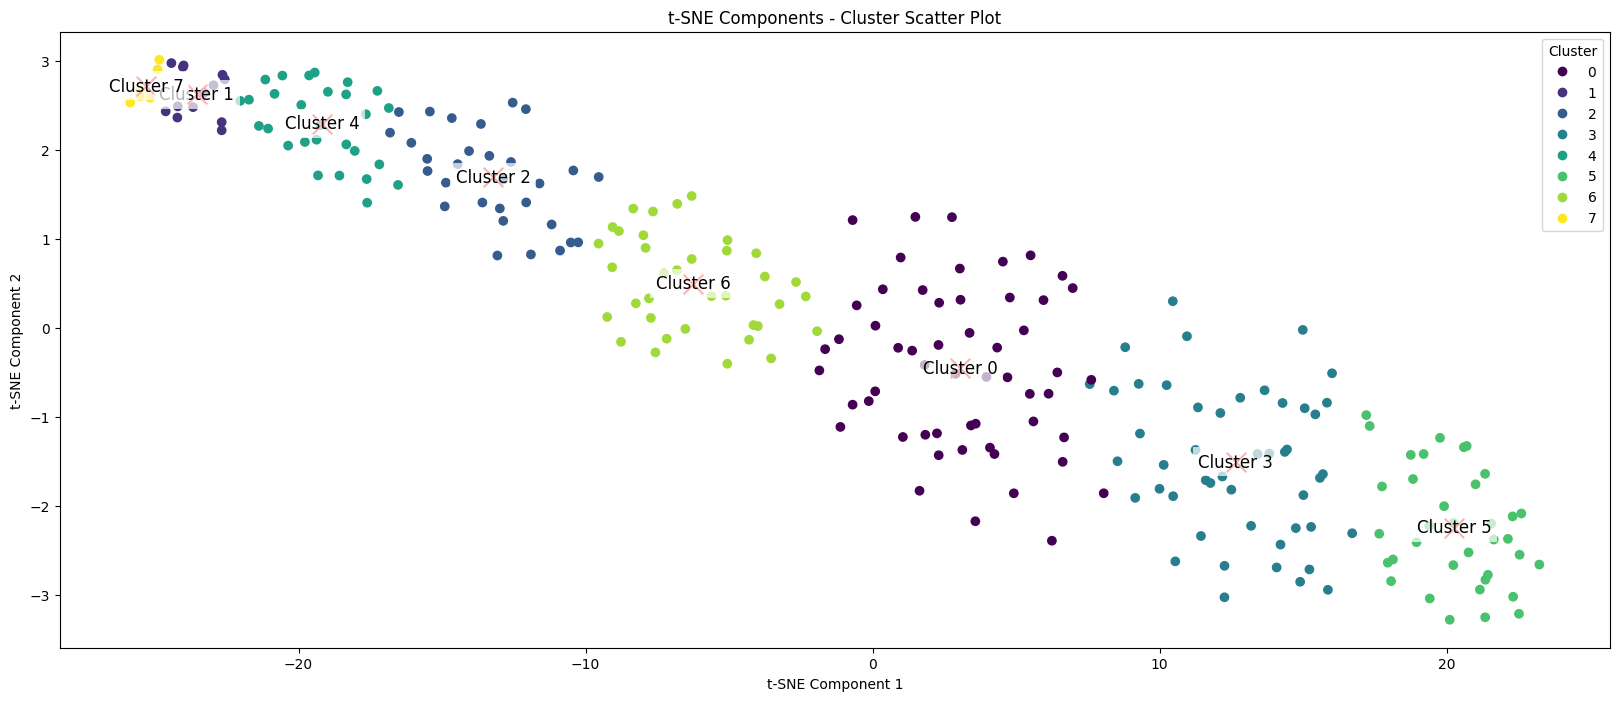

True number of documents in each category according to the class labels: [27 35 39 36 27 32 24 32]
Number of elements assigned to each cluster: [55 13 30 48 28 36 36  6]


In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_doc, cluster_sizes_doc = np.unique(kmeans.labels_, return_counts=True)

#Visualize the clusters using the t-SNE reduced data
plt.figure(figsize=(20, 8))
cluster_labels = kmeans.labels_

scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k):
    plt.text(embeddings_2d[cluster_labels == label, 0].mean(), embeddings_2d[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d[cluster_labels == label, 0].mean(), embeddings_2d[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_doc}")


### **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters

In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

Applies the fit_and_evaluate function and visualizes it

clustering done in 0.39 ± 0.03 s 
Homogeneity: 0.122 ± 0.002
Completeness: 0.130 ± 0.002
V-measure: 0.126 ± 0.002
Adjusted Rand-Index: 0.039 ± 0.001
Silhouette Coefficient: 0.170 ± 0.001


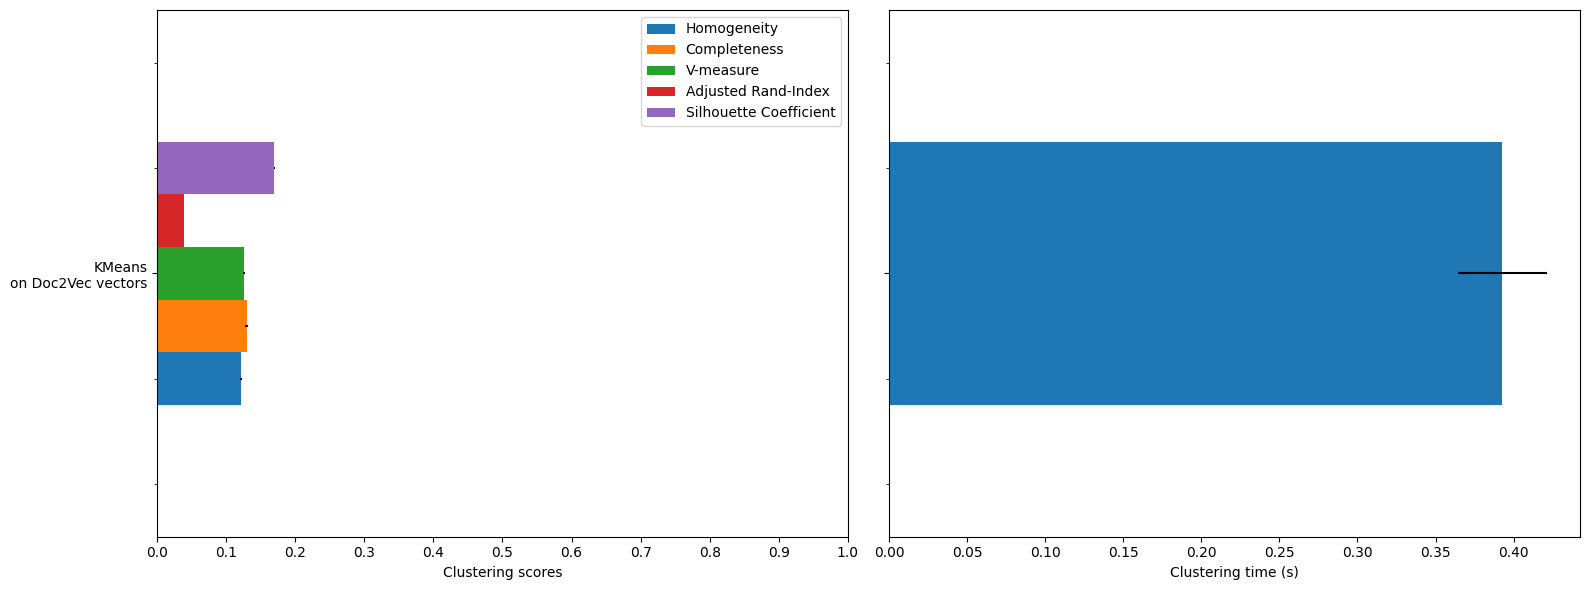

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans, np_document_embeddings_one, name="KMeans\non Doc2Vec vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

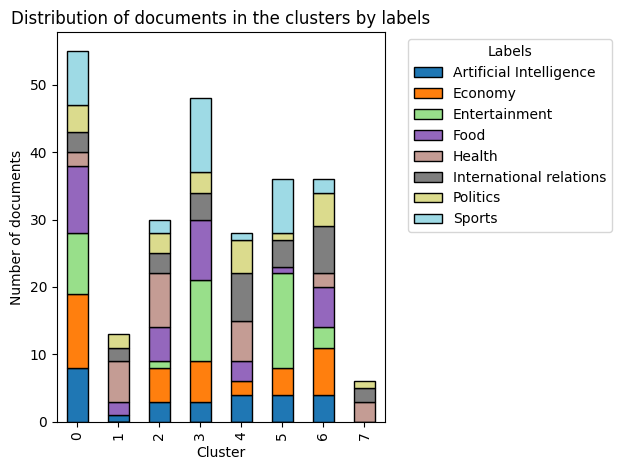

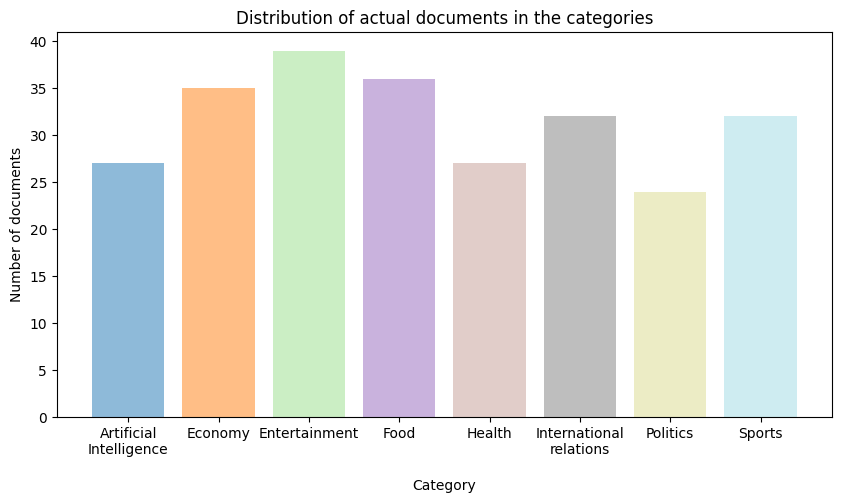


Distribution of documents in the clusters according to labels:
true_label  Artificial Intelligence   Economy  Entertainment  Food  Health  \
cluster                                                                      
0                                  8       11              9    10       2   
1                                  1        0              0     2       6   
2                                  3        5              1     5       8   
3                                  3        6             12     9       0   
4                                  4        2              0     3       6   
5                                  4        4             14     1       0   
6                                  4        7              3     6       2   
7                                  0        0              0     0       3   

true_label  International relations  Politics  Sports  
cluster                                                
0                                 3        

In [ ]:
x_labels = news_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes)), category_sizes, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_doc):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_df[news_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the DM vectors of the documents in the current category.
        category_doc = np_document_embeddings_one[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_doc)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for Economy: 0.8829109768907563
Average Cosine Similarity for Health: 0.9783699057380698
Average Cosine Similarity for Sports: 0.822831799907069
Average Cosine Similarity for Entertainment: 0.6904852863265435
Average Cosine Similarity for Politics: 0.9304357335187387
Average Cosine Similarity for International relations: 0.8827794597994897
Average Cosine Similarity for Food: 0.9056642562624008
Average Cosine Similarity for Artificial Intelligence : 0.8793940095819979


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_df[news_df['Category'] == category1].index
    category1_vector = np_document_embeddings_one[indices1]

    #Extract the documents in the second category
    indices2 = news_df[news_df['Category'] == category2].index
    category2_vector = np_document_embeddings_one[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between Economy and Health: 0.9294173717498779
Average Cosine Similarity between Sports and Entertainment: 0.7552372217178345
Average Cosine Similarity between Politics and International relations: 0.9067034721374512
Average Cosine Similarity between Food and Artificial Intelligence : 0.8923335671424866


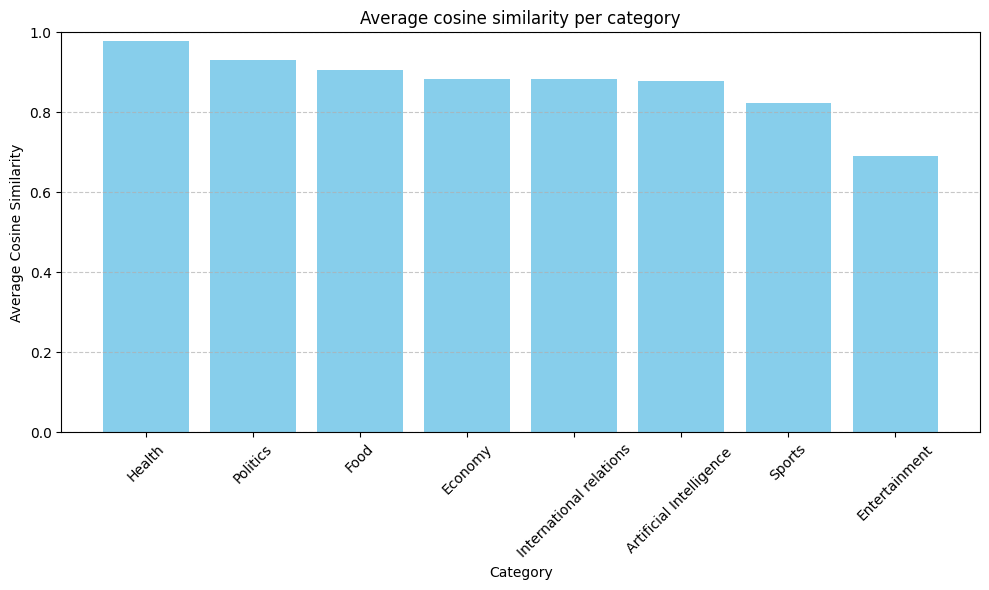

In [ ]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  #Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, np_document_embeddings_one)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

Here we create a heatmap which visually represents the top categories for each cluster


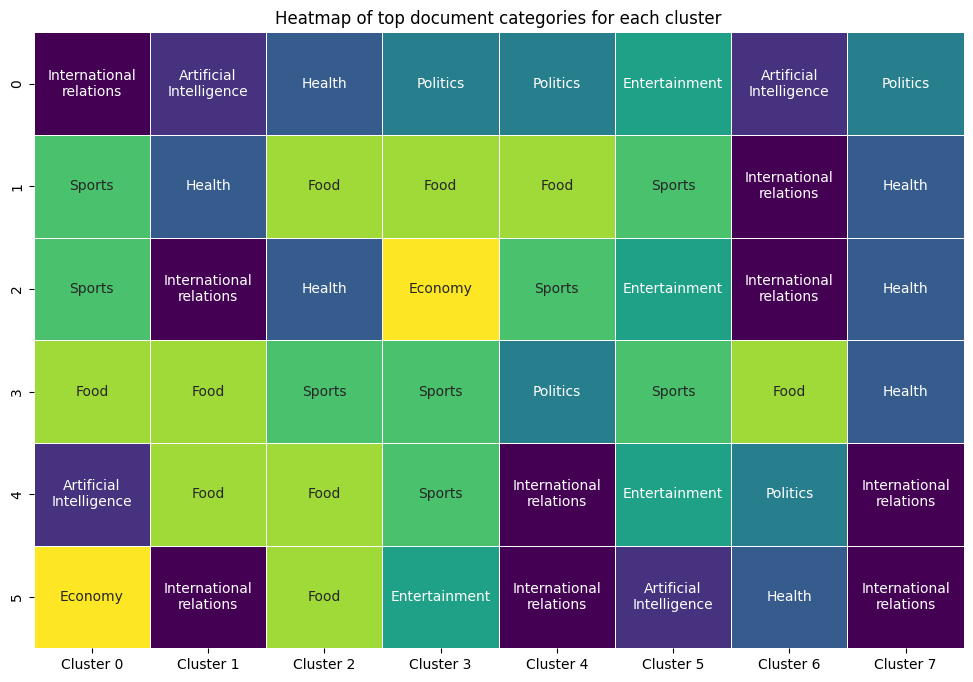

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)


#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k)])
heatmap_df = heatmap_df.T  #Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()

Now we visualize the comparison between number of documents in each cluster and actual documents in the categories


# **Doc2Vec On Second Dataset**

Doc2Vec models come in two primary variants: Distributed Memory (DM) and Distributed Bag of Words (DBOW). The DM model, proposed by Mikolov et al., extends Word2Vec's Continuous Bag of Words (CBOW) by incorporating both word context and document context to predict the next word in a sequence. In contrast, the DBOW model focuses solely on predicting the next word based on the document index, disregarding surrounding word context altogether.

##**Distributed Bag of Words**

### **Doc2Vec**

This code initializes a Doc2Vec model using the following hyperparameters.


In [ ]:
#Constructing the model with the best hyperparameters for Random Forest
model_two = Doc2Vec(dm = 0, #Indicates the Distributed Memory mode for the Doc2Vec model.
                 dm_mean = 1, #Specifies to use the mean of context word vectors in DBOW mode
                 vector_size = 300, #Sets the dimensionality of the feature vectors to 200.
                 min_count = 5, #Ignores all words with a total frequency lower than 2 during the vocabulary building process.
                 epochs = 40, #Number of iterations (epochs) over the corpus during training
                 window = 5, #Maximum distance between the predicted word and context words within a sentence.
                 alpha = 0.025, #Initial learning rate for training the model.
                 min_alpha = 0.0001, #Minimum learning rate. Learning rate will linearly drop to this value as training progresses.
                 workers = 1, #Number of worker threads to use for training the model
                 seed = 1) #Seed for reproducibility of results

 It builds the vocabulary using the tagged documents.

In [ ]:
model_two.build_vocab(tagged_data_two)

It trains the model on the tagged data for the specified number of epochs.

In [ ]:
model_two.train(tagged_data_two, total_examples=model_two.corpus_count, epochs=model_two.epochs)

Here we tokenize each document in text data, then use the Doc2Vec model  to infer embeddings for each document based on its tokenized words. The resulting document embeddings are stored as a NumPy array, capturing semantic meanings learned by the model.

In [ ]:
document_t = [word_tokenize(doc) for doc in text_data_two]

In [ ]:
embeddings_two = [model_two.infer_vector(doc) for doc in document_t]

In [ ]:
embeddings_two = np.array(embeddings_two)

### **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans_two = KMeans(
    n_clusters=true_k_two,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(embeddings_two)

Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step,PCA ia used, cause it need less time and computing power.

In [ ]:
#Reducing the dimensions of the embeddings with PCA.
pca = PCA(n_components=2)
embeddings_2d_two = pca.fit_transform(embeddings_two)

In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_doc, cluster_sizes_doc = np.unique(kmeans_two.labels_, return_counts=True)

#Visualize the clusters using the PCA reduced data
plt.figure(figsize=(25, 20))
cluster_labels = kmeans_two.labels_

scatter = plt.scatter(embeddings_2d_two[:, 0], embeddings_2d_two[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k_two):
    plt.text(embeddings_2d_two[cluster_labels == label, 0].mean(), embeddings_2d_two[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d_two[cluster_labels == label, 0].mean(), embeddings_2d_two[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes_two}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_doc}")


Output hidden; open in https://colab.research.google.com to view.

### **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters


In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=1):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels_two, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels_two, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels_two, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels_two, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


Applies the fit_and_evaluate function and visualizes it

clustering done in 243.18 ± 0.00 s 
Homogeneity: 0.272 ± 0.000
Completeness: 0.275 ± 0.000
V-measure: 0.273 ± 0.000
Adjusted Rand-Index: 0.199 ± 0.000
Silhouette Coefficient: -0.057 ± 0.000


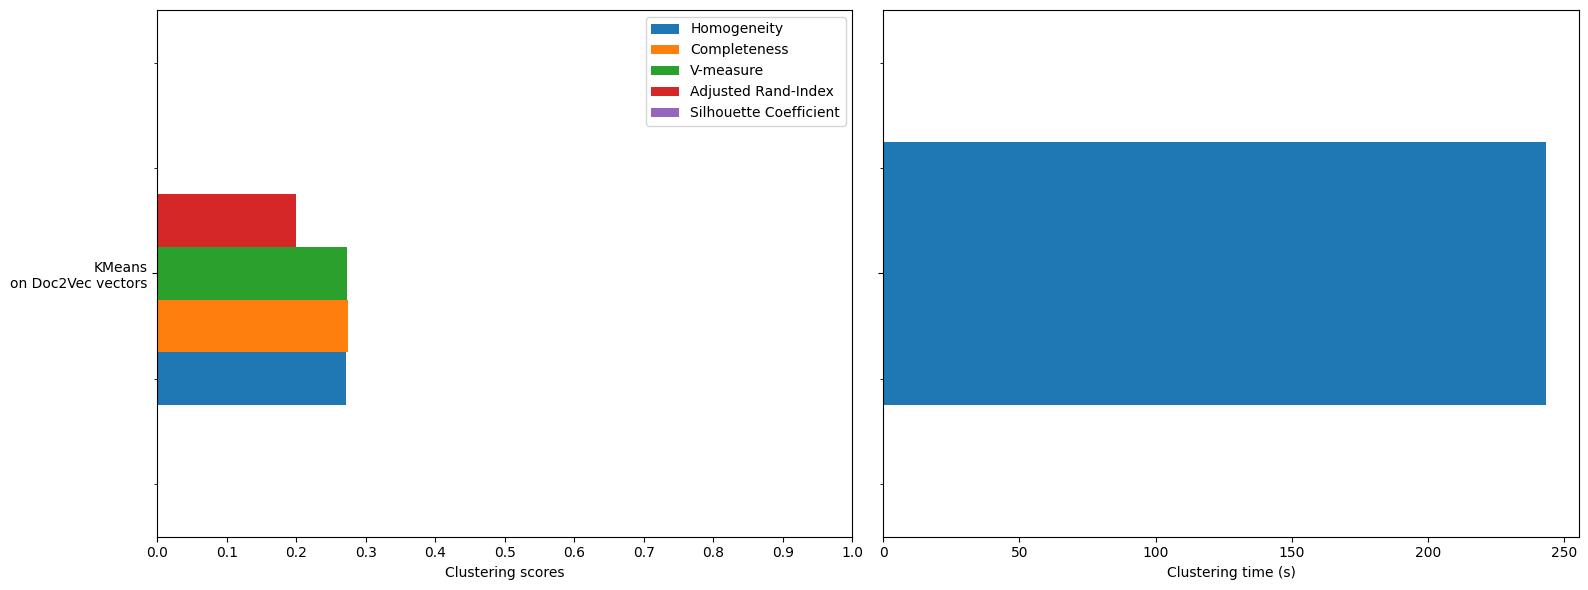

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans_two, embeddings_two, name="KMeans\non Doc2Vec vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

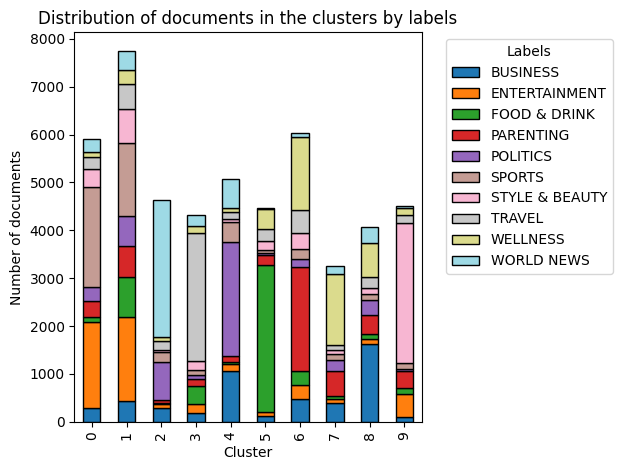

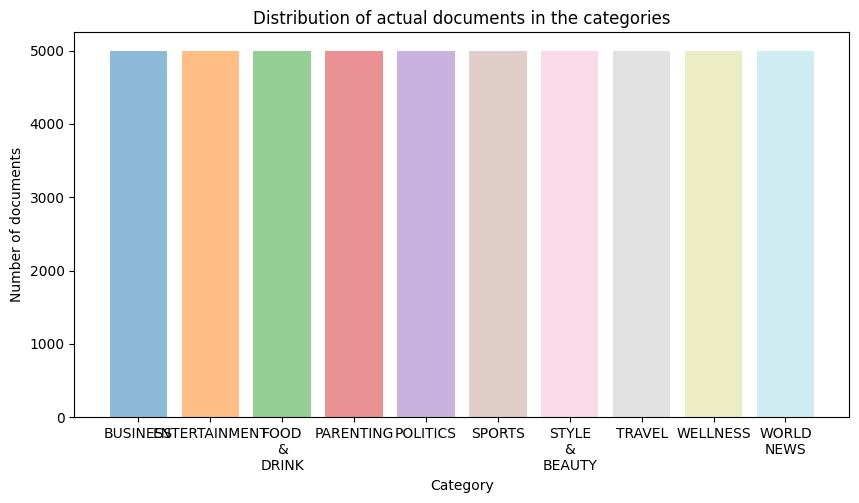


Distribution of documents in the clusters according to labels:
true_label  BUSINESS  ENTERTAINMENT  FOOD & DRINK  PARENTING  POLITICS  \
cluster                                                                  
0                295           1797            95        342       295   
1                439           1742           839        662       617   
2                294             73            23         70       782   
3                192            189           370        139        92   
4               1055            158            27        130      2391   
5                114             87          3076        213        39   
6                485            277           310       2165       165   
7                390             88            53        529       240   
8               1631            102            99        393       325   
9                105            487           108        357        54   

true_label  SPORTS  STYLE & BEAUTY  TRAVEL  WEL

In [ ]:
x_labels = news_two_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_two_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes_two = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes_two)), category_sizes_two, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes_two)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_doc):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes_two):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_two_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_two_df[news_two_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the DBOW vectors of the documents in the current category.
        category_doc = embeddings_two[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_doc)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  # Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  # Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  # If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for WELLNESS: 0.2600824964992999
Average Cosine Similarity for POLITICS: 0.3080237447489498
Average Cosine Similarity for ENTERTAINMENT: 0.32693156631326264
Average Cosine Similarity for TRAVEL: 0.25966419283856773
Average Cosine Similarity for STYLE & BEAUTY: 0.3153770954190838
Average Cosine Similarity for PARENTING: 0.26314160832166433
Average Cosine Similarity for FOOD & DRINK: 0.3650174834966993
Average Cosine Similarity for WORLD NEWS: 0.3260125825165033
Average Cosine Similarity for BUSINESS: 0.2732750550110022
Average Cosine Similarity for SPORTS: 0.33459753950790155


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_two_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_two_df[news_two_df['Category'] == category1].index
    category1_vector = embeddings_two[indices1]

    #Extract the documents in the second category
    indices2 = news_two_df[news_two_df['Category'] == category2].index
    category2_vector = embeddings_two[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between WELLNESS and POLITICS: 0.2419176548719406
Average Cosine Similarity between ENTERTAINMENT and TRAVEL: 0.2595631778240204
Average Cosine Similarity between STYLE & BEAUTY and PARENTING: 0.25235071778297424
Average Cosine Similarity between FOOD & DRINK and WORLD NEWS: 0.2506905496120453
Average Cosine Similarity between BUSINESS and SPORTS: 0.27097561955451965


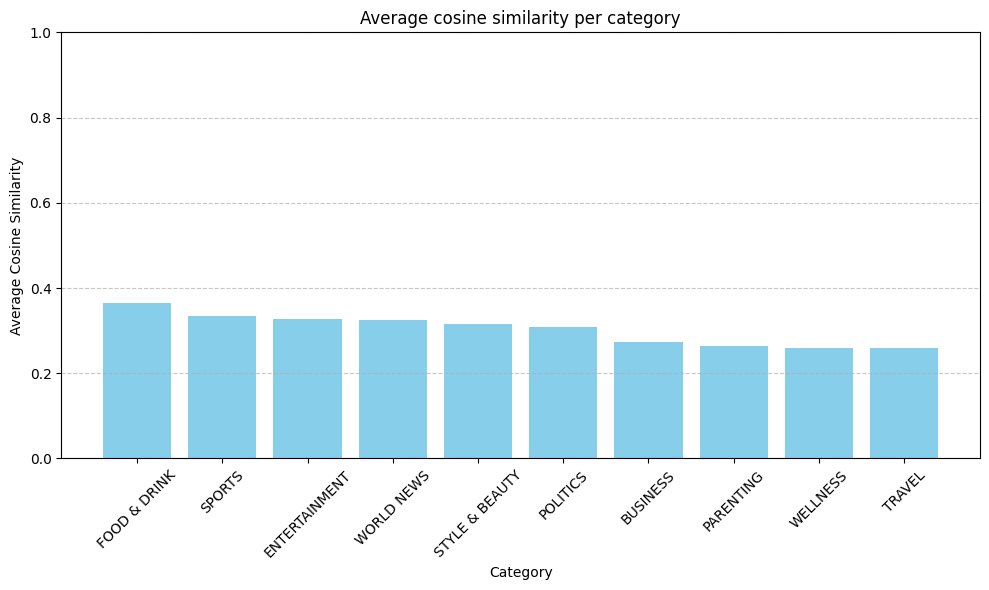

In [ ]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  #Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k_two):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans_two.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, embeddings_two)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

 Here we create a heatmap which visually represents the top categories for each cluster based on the cosine similarity. The documents are sorted in descending order according to their similarity to the cluster center.

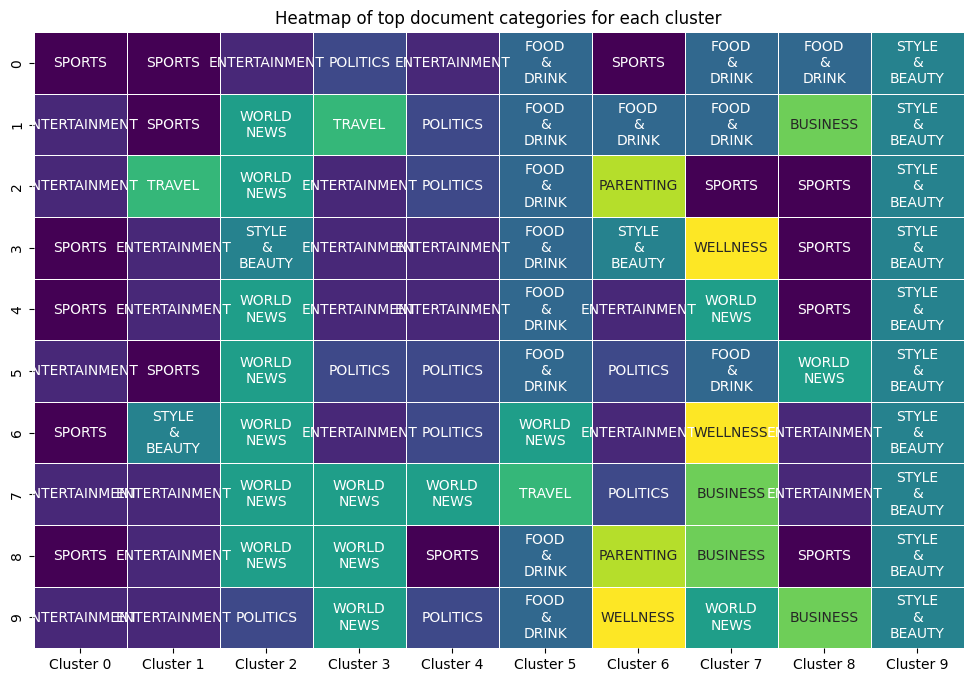

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_two_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)

#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k_two)])
heatmap_df = heatmap_df.T  # Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()


##**Distributed Memory**

### **Doc2Vec**

In [ ]:
#Constructing the model with the best hyperparameters for Random Forest
model_two_one = Doc2Vec(dm = 1, #Indicates the Distributed Memory mode for the Doc2Vec model.
                 dm_mean = 1, #Specifies to use the mean of context word vectors in DBOW mode
                 vector_size = 200, #Sets the dimensionality of the feature vectors to 200.
                 min_count = 5, #Ignores all words with a total frequency lower than 2 during the vocabulary building process.
                 epochs = 20, #Number of iterations (epochs) over the corpus during training
                 window = 5, #Maximum distance between the predicted word and context words within a sentence.
                 alpha = 0.025, #Initial learning rate for training the model.
                 min_alpha = 0.0001, #Minimum learning rate. Learning rate will linearly drop to this value as training progresses.
                 workers = 1, #Number of worker threads to use for training the model
                 seed = 1) #Seed for reproducibility of results

 It builds the vocabulary using the tagged documents.

In [ ]:
model_two_one.build_vocab(tagged_data_two)

It trains the model on the tagged data for the specified number of epochs.

In [ ]:
model_two_one.train(tagged_data_two, total_examples=model_two_one.corpus_count, epochs=model_two_one.epochs)

Here we tokenize each document in the text data, then use the Doc2Vec model  to infer embeddings for each document based on its tokenized words. The resulting document embeddings are stored as a NumPy array, capturing semantic meanings learned by the model.

In [ ]:
document_t_one = [word_tokenize(doc) for doc in text_data_two]

In [ ]:
embeddings_two = [model_two_one.infer_vector(doc) for doc in document_t]

In [ ]:
embeddings_two = np.array(embeddings_two)

### **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans_two = KMeans(
    n_clusters=true_k_two,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(embeddings_two)

Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, PCA is used, cause it need less time and computing power.

In [ ]:
#Reducing the dimensions of the embeddings with PCA.
pca = PCA(n_components=2)
embeddings_2d_two = pca.fit_transform(embeddings_two)

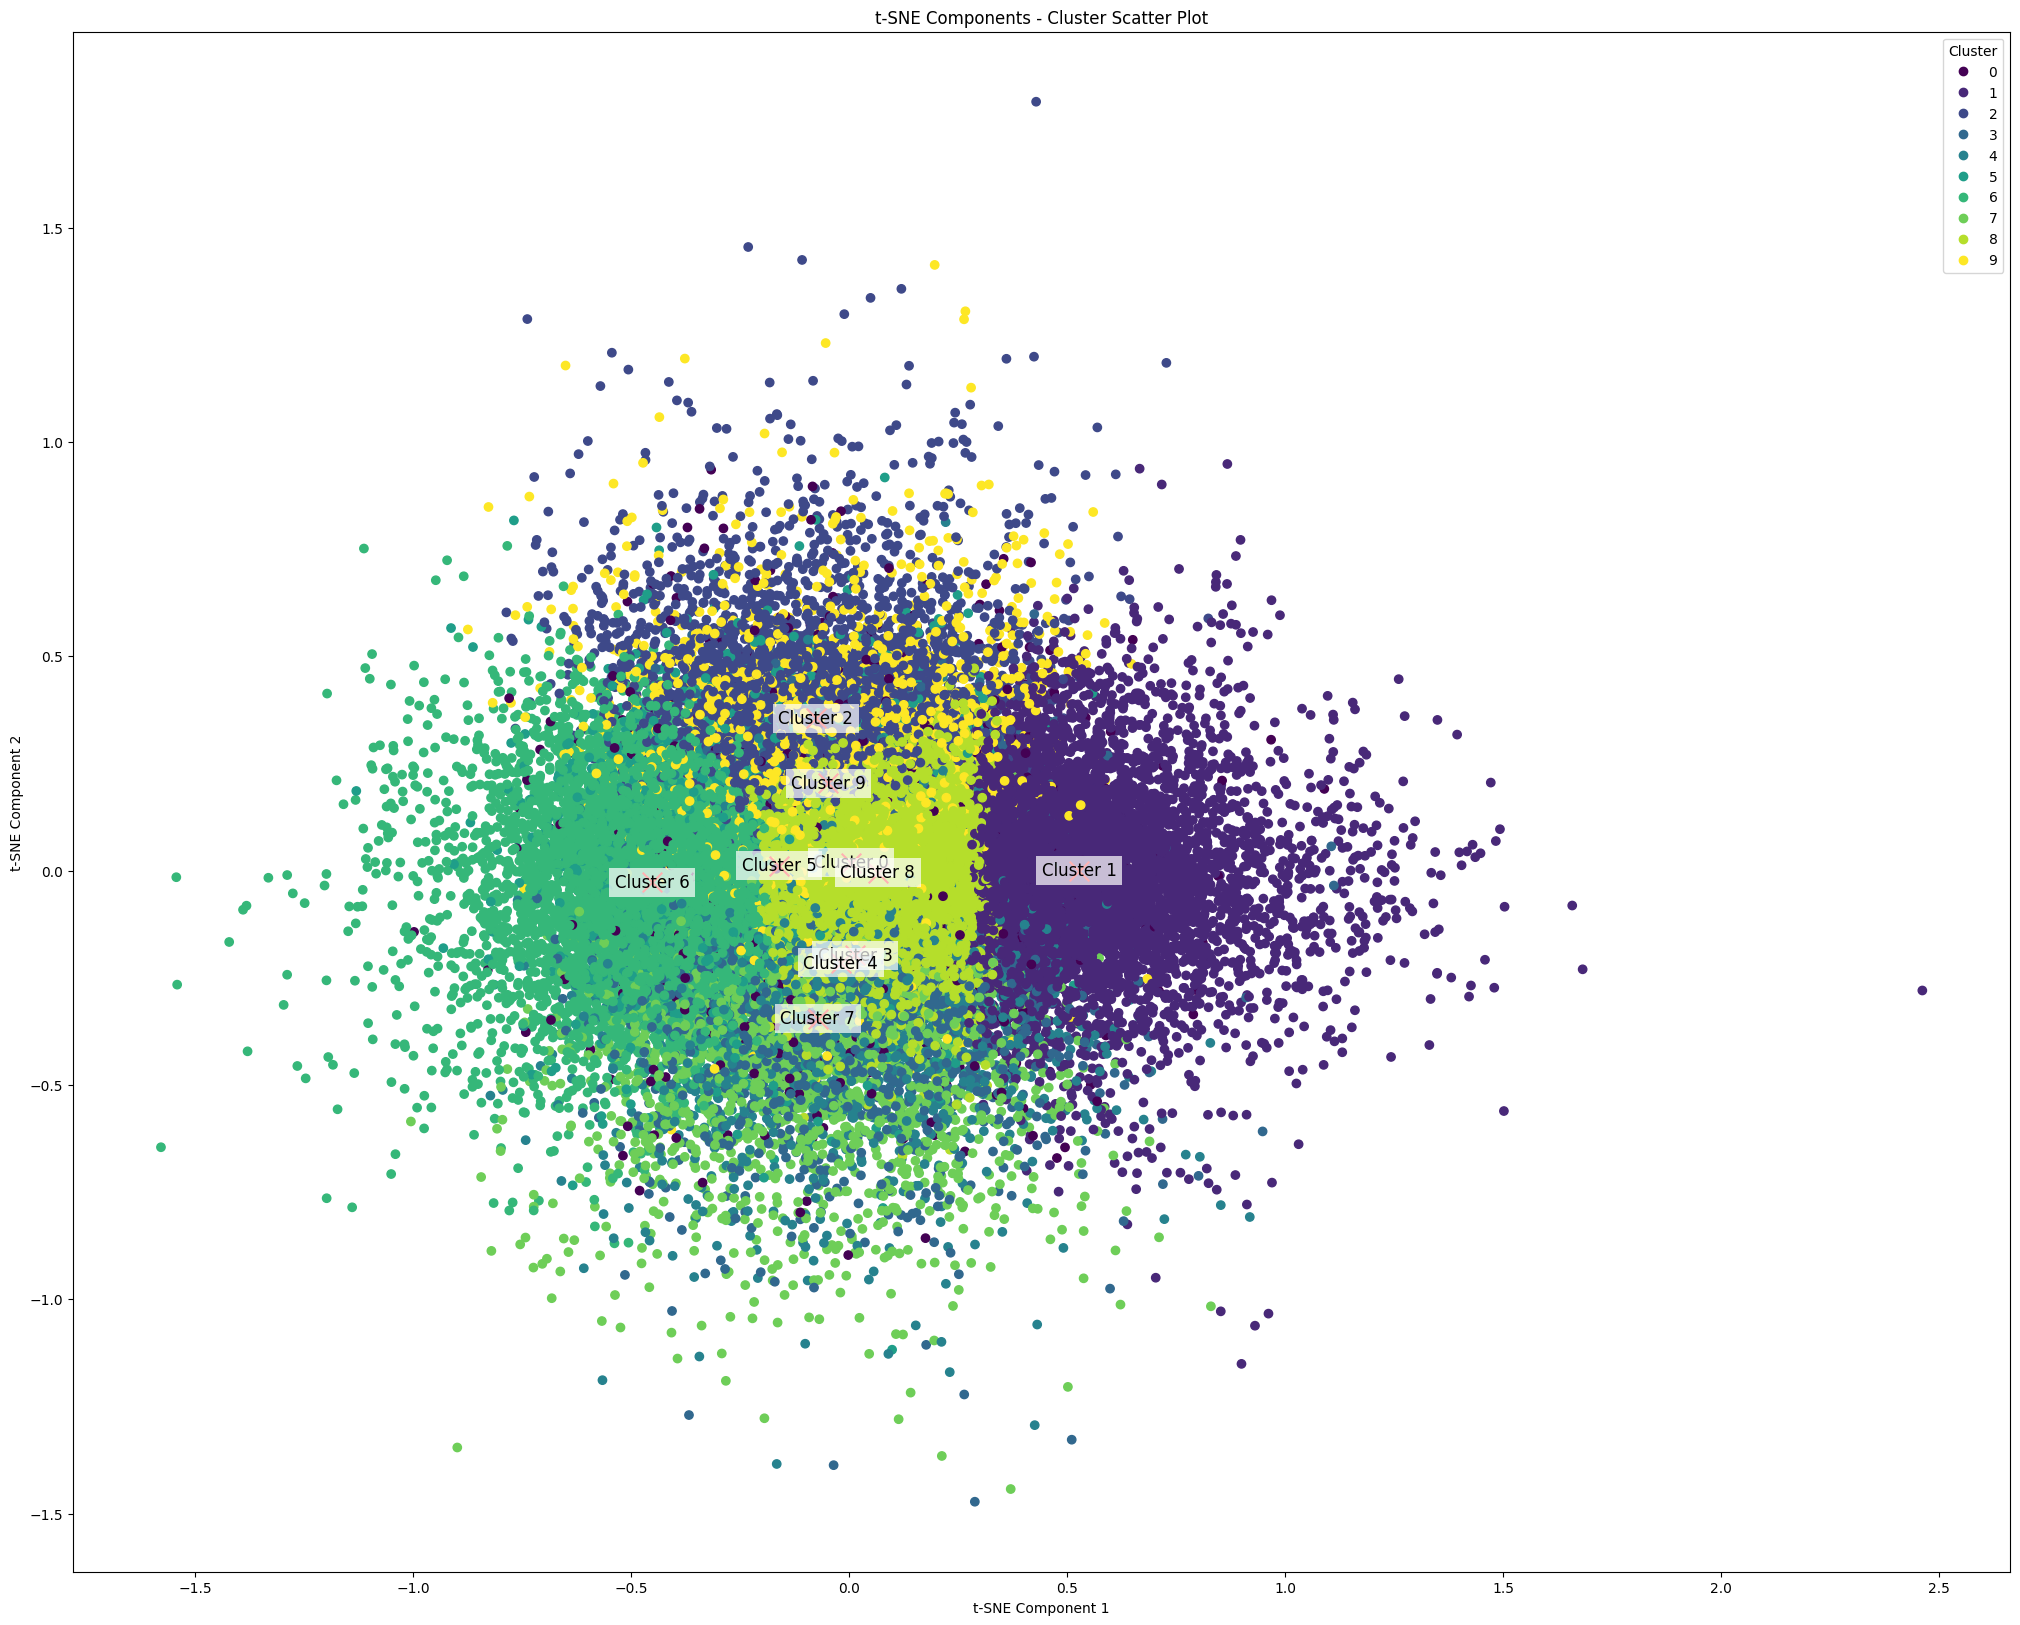

True number of documents in each category according to the class labels: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Number of elements assigned to each cluster: [ 1045  7655  4680  3003  2646  4198  7605  2984 12577  3607]


In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_doc, cluster_sizes_doc = np.unique(kmeans_two.labels_, return_counts=True)

#Visualize the clusters using the PCA reduced data
plt.figure(figsize=(25, 20))
cluster_labels = kmeans_two.labels_

scatter = plt.scatter(embeddings_2d_two[:, 0], embeddings_2d_two[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k_two):
    plt.text(embeddings_2d_two[cluster_labels == label, 0].mean(), embeddings_2d_two[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d_two[cluster_labels == label, 0].mean(), embeddings_2d_two[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes_two}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_doc}")


### **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters


In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=1):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels_two, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels_two, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels_two, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels_two, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


Applies the fit_and_evaluate function and visualizes it

clustering done in 155.92 ± 0.00 s 
Homogeneity: 0.044 ± 0.000
Completeness: 0.049 ± 0.000
V-measure: 0.046 ± 0.000
Adjusted Rand-Index: 0.023 ± 0.000
Silhouette Coefficient: -0.047 ± 0.000


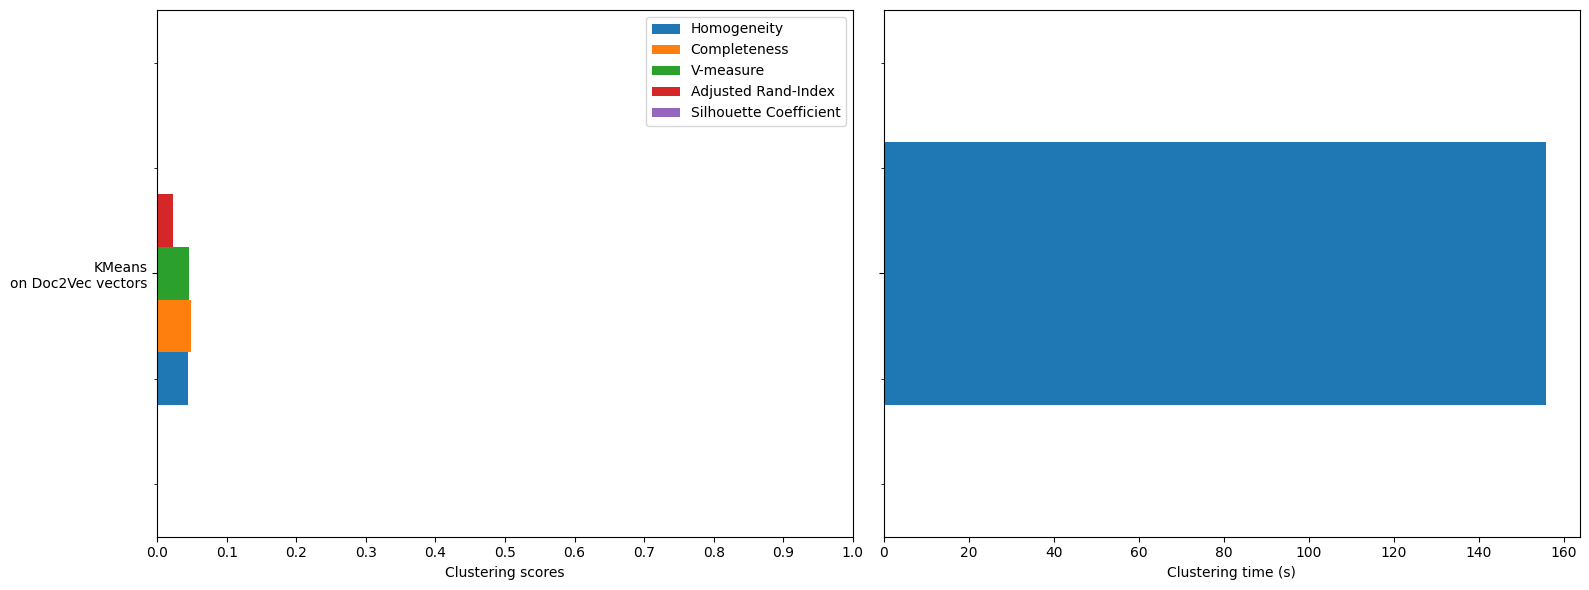

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans_two, embeddings_two, name="KMeans\non Doc2Vec vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

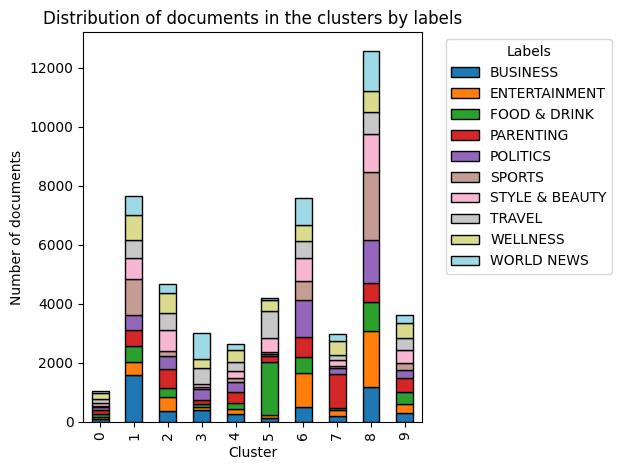

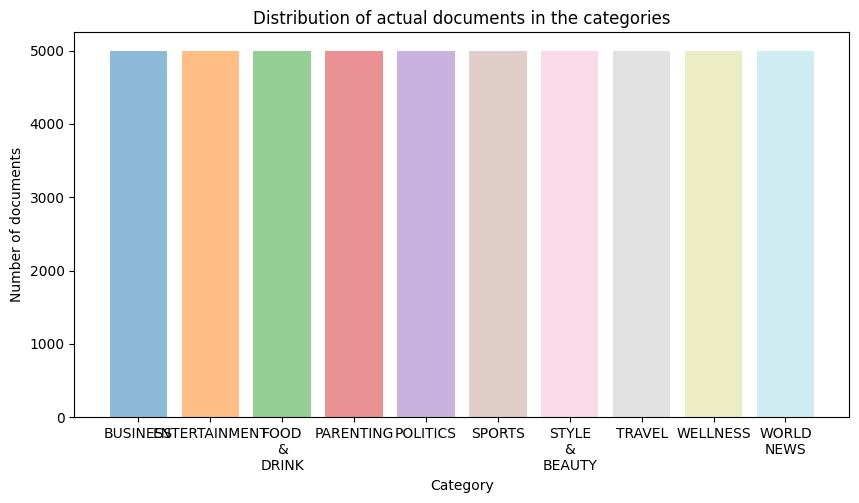


Distribution of documents in the clusters according to labels:
true_label  BUSINESS  ENTERTAINMENT  FOOD & DRINK  PARENTING  POLITICS  \
cluster                                                                  
0                 84             75           104        149        88   
1               1580            460           519        559       509   
2                364            477           306        633       442   
3                412            104            94        132       377   
4                256            186           204        371       320   
5                122            117          1804        199        43   
6                517           1142           539        668      1261   
7                199            201            77       1145       211   
8               1179           1907           961        673      1458   
9                287            331           392        471       291   

true_label  SPORTS  STYLE & BEAUTY  TRAVEL  WEL

In [ ]:
x_labels = news_two_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_two_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes_two = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes_two)), category_sizes_two, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes_two)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_doc):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes_two):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_two_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_two_df[news_two_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the DM vectors of the documents in the current category.
        category_doc = embeddings_two[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_doc)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for WELLNESS: 0.12326478295659132
Average Cosine Similarity for POLITICS: 0.14810612122424485
Average Cosine Similarity for ENTERTAINMENT: 0.18651366273254652
Average Cosine Similarity for TRAVEL: 0.1294995899179836
Average Cosine Similarity for STYLE & BEAUTY: 0.16352034406881377
Average Cosine Similarity for PARENTING: 0.11160400080016003
Average Cosine Similarity for FOOD & DRINK: 0.1838255051010202
Average Cosine Similarity for WORLD NEWS: 0.18107121424284858
Average Cosine Similarity for BUSINESS: 0.22103026605321063
Average Cosine Similarity for SPORTS: 0.3225526305261052


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_two_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_two_df[news_two_df['Category'] == category1].index
    category1_vector = embeddings_two[indices1]

    #Extract the documents in the second category
    indices2 = news_two_df[news_two_df['Category'] == category2].index
    category2_vector = embeddings_two[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between WELLNESS and POLITICS: 0.11263646930456161
Average Cosine Similarity between ENTERTAINMENT and TRAVEL: 0.12556859850883484
Average Cosine Similarity between STYLE & BEAUTY and PARENTING: 0.11227043718099594
Average Cosine Similarity between FOOD & DRINK and WORLD NEWS: 0.1363261342048645
Average Cosine Similarity between BUSINESS and SPORTS: 0.2464064657688141


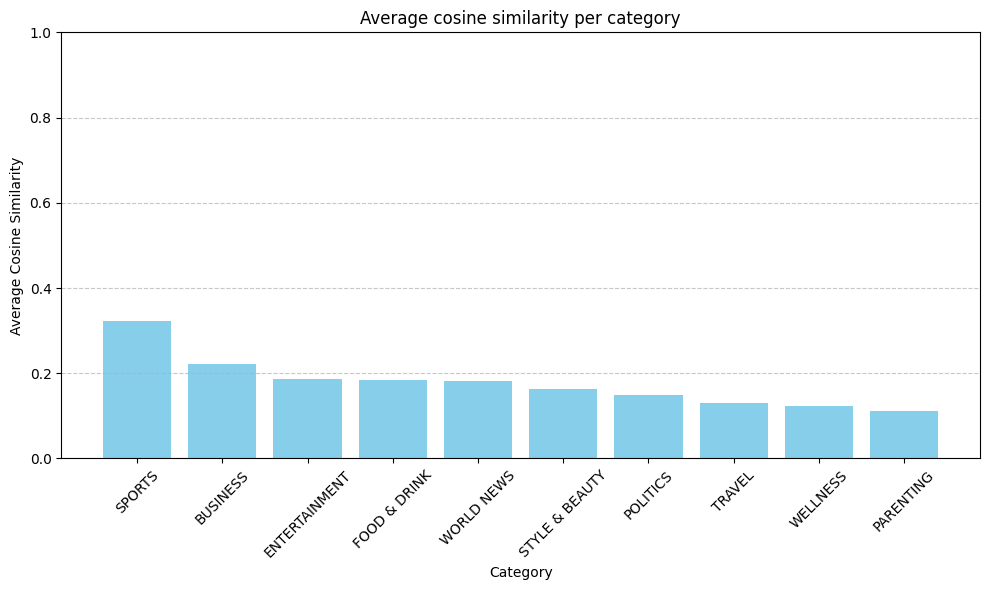

In [ ]:
# Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k_two):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans_two.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, embeddings_two)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

 Here we create a heatmap which visually represents the top categories for each cluster based on the cosine similarity. The documents are sorted in descending order according to their similarity to the cluster center.

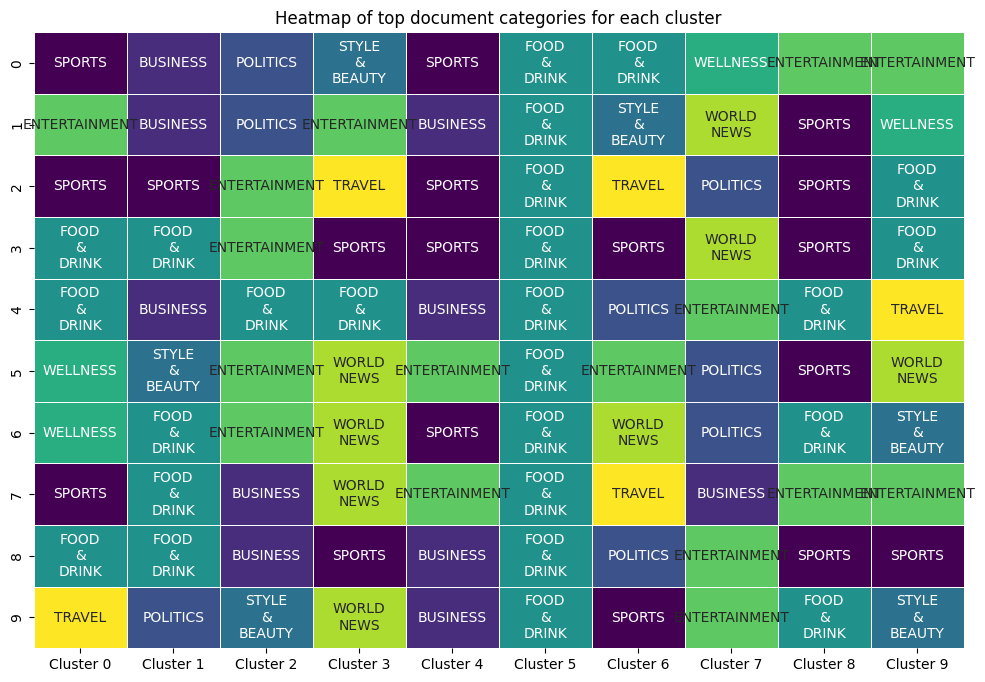

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_two_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)

#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k_two)])
heatmap_df = heatmap_df.T  # Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()


# **Doc2Vec On Third Dataset**

Doc2Vec models come in two primary variants: Distributed Memory (DM) and Distributed Bag of Words (DBOW). The DM model, proposed by Mikolov et al., extends Word2Vec's Continuous Bag of Words (CBOW) by incorporating both word context and document context to predict the next word in a sequence. In contrast, the DBOW model focuses solely on predicting the next word based on the document index, disregarding surrounding word context altogether.

##**Distributed Bag of Words**



### **Doc2Vec**

This code initializes a Doc2Vec model using the following hyperparameters.


In [ ]:
#Constructing the model with the best hyperparameters for Random Forest
model_three = Doc2Vec(dm = 0, #Indicates the Distributed Memory mode for the Doc2Vec model.
                 dm_mean = 1, #Specifies to use the mean of context word vectors in DBOW mode
                 vector_size = 300, #Sets the dimensionality of the feature vectors to 200.
                 min_count = 5, #Ignores all words with a total frequency lower than 2 during the vocabulary building process.
                 epochs = 40, #Number of iterations (epochs) over the corpus during training
                 window = 5, #Maximum distance between the predicted word and context words within a sentence.
                 alpha = 0.025, #Initial learning rate for training the model.
                 min_alpha = 0.0001, #Minimum learning rate. Learning rate will linearly drop to this value as training progresses.
                 workers = 1, #Number of worker threads to use for training the model
                 seed = 1) #Seed for reproducibility of results

 It builds the vocabulary using the tagged documents.

In [ ]:
model_three.build_vocab(tagged_data_three)

It trains the model on the tagged data for the specified number of epochs.

In [ ]:
model_three.train(tagged_data_three, total_examples=model_three.corpus_count, epochs=model_three.epochs)

Here we tokenize each document in the text data, then use the Doc2Vec model  to infer embeddings for each document based on its tokenized words. The resulting document embeddings are stored as a NumPy array, capturing semantic meanings learned by the model.

In [ ]:
document_t = [word_tokenize(doc) for doc in text_data_three]

In [ ]:
embeddings_three = [model_three.infer_vector(doc) for doc in document_t]

In [ ]:
embeddings_three = np.array(embeddings_three)

### **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans_three = KMeans(
    n_clusters=true_k_three,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(embeddings_three)

Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, PCA is used, cause it need less time and computing power.

In [ ]:
#Reducing the dimensions of the embeddings with PCA.
pca = PCA(n_components=2)
embeddings_2d_three = pca.fit_transform(embeddings_three)

In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_doc, cluster_sizes_doc = np.unique(kmeans_three.labels_, return_counts=True)

#Visualize the clusters using the PCA reduced data
plt.figure(figsize=(40, 35))
cluster_labels = kmeans_three.labels_

scatter = plt.scatter(embeddings_2d_three[:, 0], embeddings_2d_three[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k_three):
    plt.text(embeddings_2d_three[cluster_labels == label, 0].mean(), embeddings_2d_three[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d_three[cluster_labels == label, 0].mean(), embeddings_2d_three[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes_three}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_doc}")


Output hidden; open in https://colab.research.google.com to view.

### **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters


In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=1):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels_three, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels_three, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels_three, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels_three, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


Applies the fit_and_evaluate function and visualizes it

clustering done in 310.06 ± 0.00 s 
Homogeneity: 0.370 ± 0.000
Completeness: 0.363 ± 0.000
V-measure: 0.367 ± 0.000
Adjusted Rand-Index: 0.326 ± 0.000
Silhouette Coefficient: 0.028 ± 0.000


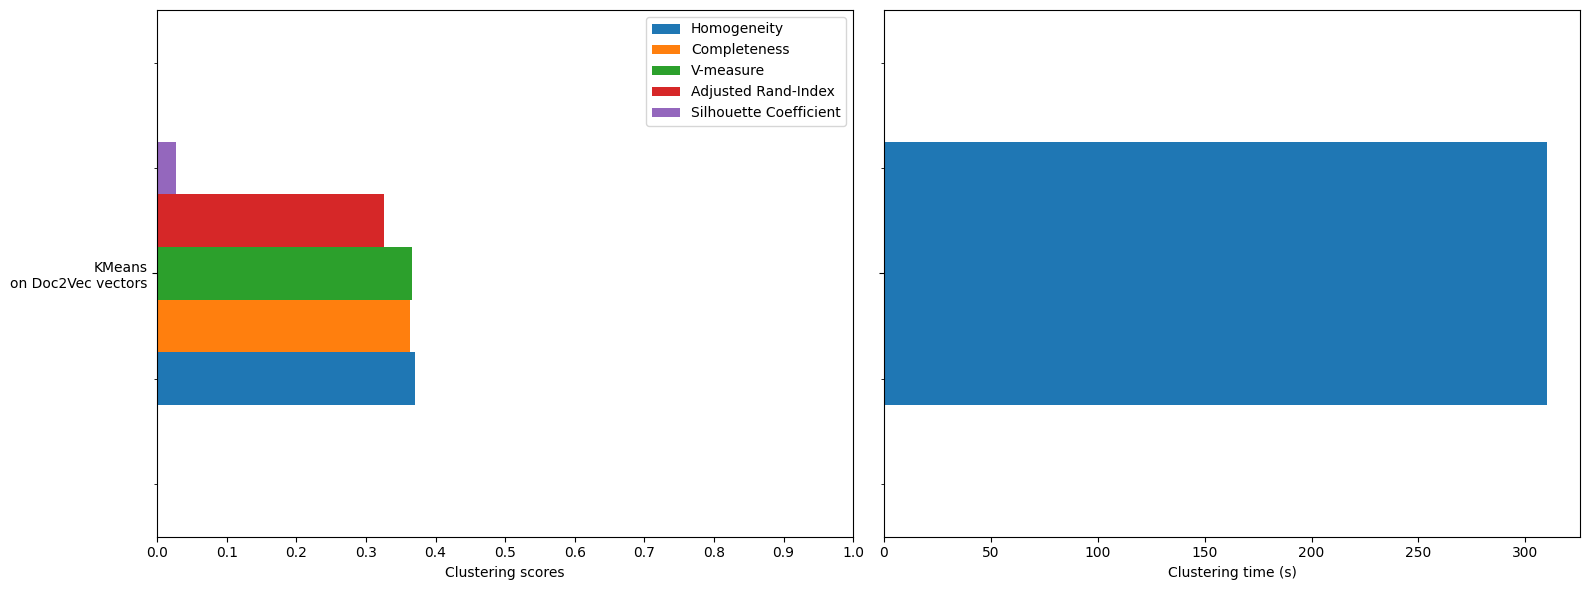

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans_three, embeddings_three, name="KMeans\non Doc2Vec vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

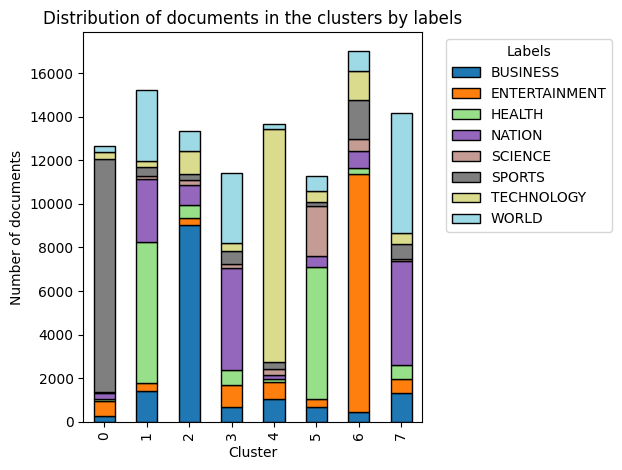

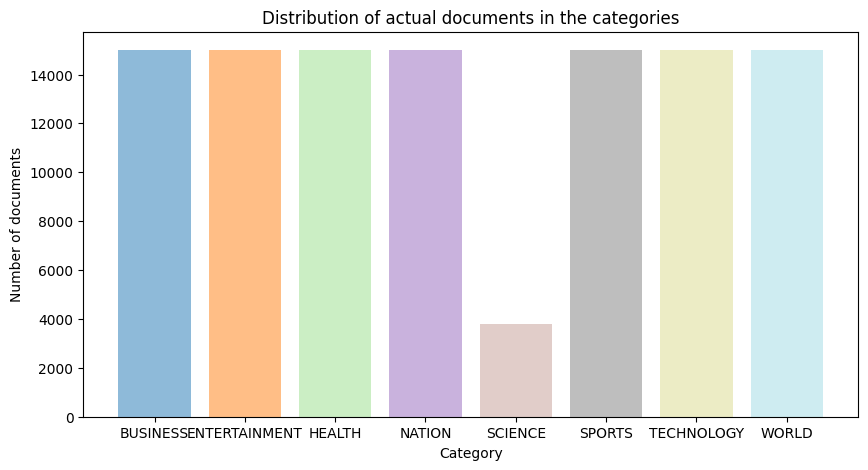


Distribution of documents in the clusters according to labels:
true_label  BUSINESS  ENTERTAINMENT  HEALTH  NATION  SCIENCE  SPORTS  \
cluster                                                                
0                277            667     113     269       45   10688   
1               1431            362    6474    2855      138     429   
2               9042            307     623     895      234     293   
3                703            987     699    4680      179     601   
4               1069            777     124     195      268     310   
5                689            374    6049     515     2266     183   
6                461          10903     272     795      563    1795   
7               1328            623     646    4796       81     701   

true_label  TECHNOLOGY  WORLD  
cluster                        
0                  335    257  
1                  262   3293  
2                 1023    939  
3                  336   3224  
4                10712 

In [ ]:
x_labels = news_three_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_three_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes_three = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes_three)), category_sizes_three, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes_three)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_doc):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes_three):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_three_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_three_df[news_three_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the DBOW vectors of the documents in the current category.
        category_doc = embeddings_three[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_doc)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for SCIENCE: 0.39499176293894184
Average Cosine Similarity for TECHNOLOGY: 0.37480027557392714
Average Cosine Similarity for HEALTH: 0.395540076005067
Average Cosine Similarity for WORLD: 0.3277926972909305
Average Cosine Similarity for ENTERTAINMENT: 0.3199427161810787
Average Cosine Similarity for SPORTS: 0.3482451185634598
Average Cosine Similarity for BUSINESS: 0.3511439784874547
Average Cosine Similarity for NATION: 0.3125309509522857


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_three_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  #Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_three_df[news_three_df['Category'] == category1].index
    category1_vector = embeddings_three[indices1]

    #Extract the documents in the second category
    indices2 = news_three_df[news_three_df['Category'] == category2].index
    category2_vector = embeddings_three[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between SCIENCE and TECHNOLOGY: 0.3100120723247528
Average Cosine Similarity between HEALTH and WORLD: 0.32847169041633606
Average Cosine Similarity between ENTERTAINMENT and SPORTS: 0.28417453169822693
Average Cosine Similarity between BUSINESS and NATION: 0.28979331254959106


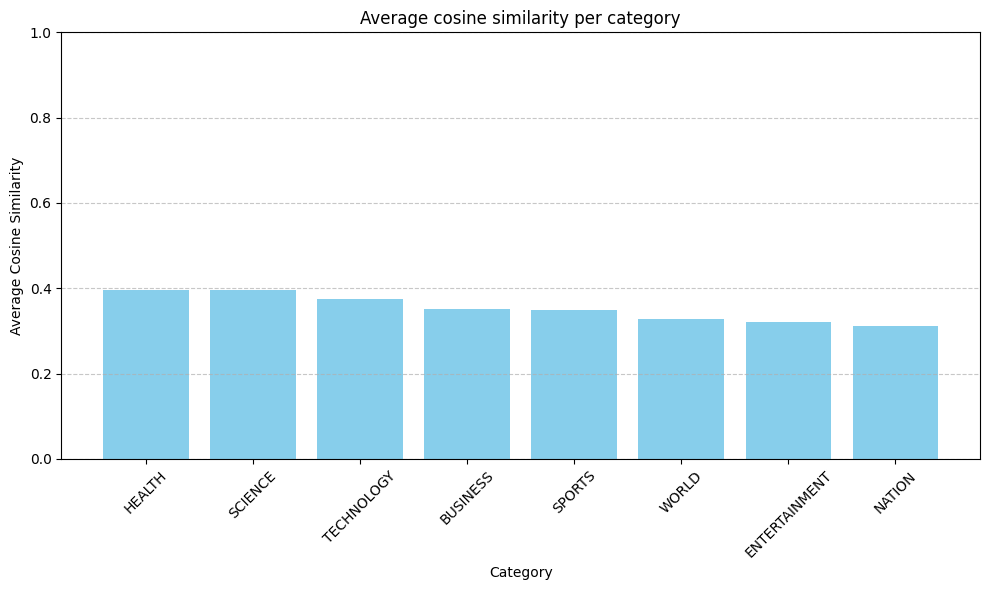

In [ ]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k_three):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans_three.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, embeddings_three)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

Here we create a heatmap which visually represents the top categories for each cluster based on the cosine similarity. The documents are sorted in descending order according to their similarity to the cluster center.

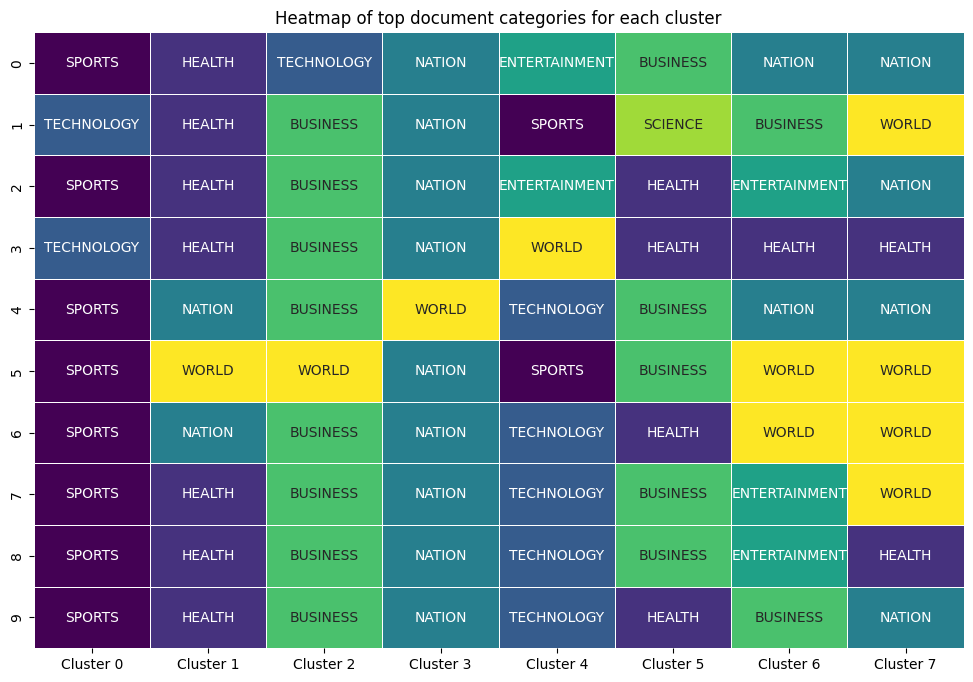

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_three_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)

#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k)])
heatmap_df = heatmap_df.T  # Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()


##**Distributed Memory**

### **Doc2Vec**

This code initializes a Doc2Vec model using the following hyperparameters.


In [ ]:
#Constructing the model with the best hyperparameters for Random Forest
model_three_one = Doc2Vec(dm = 1, #Indicates the Distributed Memory mode for the Doc2Vec model.
                 dm_mean = 1, #Specifies to use the mean of context word vectors in DBOW mode
                 vector_size = 300, #Sets the dimensionality of the feature vectors to 200.
                 min_count = 5, #Ignores all words with a total frequency lower than 2 during the vocabulary building process.
                 epochs = 40, #Number of iterations (epochs) over the corpus during training
                 window = 5, #Maximum distance between the predicted word and context words within a sentence.
                 alpha = 0.025, #Initial learning rate for training the model.
                 min_alpha = 0.0001, #Minimum learning rate. Learning rate will linearly drop to this value as training progresses.
                 workers = 1, #Number of worker threads to use for training the model
                 seed = 1) #Seed for reproducibility of results

 It builds the vocabulary using the tagged documents.

In [ ]:
model_three_one.build_vocab(tagged_data_three)

It trains the model on the tagged data for the specified number of epochs.

In [ ]:
model_three_one.train(tagged_data_three, total_examples=model_three_one.corpus_count, epochs=model_three_one.epochs)

Here we tokenize each document in the text data, then use the Doc2Vec model  to infer embeddings for each document based on its tokenized words. The resulting document embeddings are stored as a NumPy array, capturing semantic meanings learned by the model.

In [ ]:
document_t_one = [word_tokenize(doc) for doc in text_data_three]

In [ ]:
embeddings_three = [model_two_one.infer_vector(doc) for doc in document_t]

In [ ]:
embeddings_three = np.array(embeddings_three)

### **Clustering**

Trains the KMeans clustering algorithm and visualizes the clusters in a scatter plot. It also prints the number of elements assigned to each cluster.

In [ ]:
#Initialize and train KMeans clustering algorithm
kmeans_three = KMeans(
    n_clusters=true_k_three,  #Number of clusters
    init = 'k-means++', #Initialization method
    max_iter=100,       #Maximum number of iterations
    n_init=50,          #Number of times it will run with different initial centroids
    random_state=1,  #Random seed for reproducibility
).fit(embeddings_three)

Dimensionality reduction is used to visualize data in a low-dimensional space. In this case, the feature dimensions are reduced to two to make complex relationships between the data points easier to visualize. For this step, PCA is used, cause it need less time and computing power.

In [ ]:
#Reducing the dimensions of the embeddings with PCA.
pca = PCA(n_components=2)
embeddings_2d_three = pca.fit_transform(embeddings_three)

In [ ]:
#Calculate the number of elements assigned to each cluster
cluster_ids_doc, cluster_sizes_doc = np.unique(kmeans_three.labels_, return_counts=True)

#Visualize the clusters using the PCA reduced data
plt.figure(figsize=(40, 35))
cluster_labels = kmeans_three.labels_

scatter = plt.scatter(embeddings_2d_three[:, 0], embeddings_2d_three[:, 1], c=cluster_labels, cmap='viridis')

#Add labels und center points to the clusters
for label in range(true_k_three):
    plt.text(embeddings_2d_three[cluster_labels == label, 0].mean(), embeddings_2d_three[cluster_labels == label, 1].mean(),
             f'Cluster {label}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.scatter(embeddings_2d_three[cluster_labels == label, 0].mean(), embeddings_2d_three[cluster_labels == label, 1].mean(), marker='x', color='red', s=200, label='Cluster Centers')


#Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Components - Cluster Scatter Plot')

#Add legend
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

#Show the scatter plot
plt.show()

print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes_three}"
)
print(f"Number of elements assigned to each cluster: {cluster_sizes_doc}")


Output hidden; open in https://colab.research.google.com to view.

### **Evaluation**

Clustering is usually an unsupervised method, but since we have labels for the data set, the quality of clustering can be assessed using various metrics [[1]](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py).

These metrics are used top evaluate the clustering:


*   Homogenity: Quantifies how much clusters contain only samples of a single class
*   Completeness: Measures how well al samples of a given class are assigned to the same cluster
* V-measure: Combines homogenity and completeness providing a balanced measurte of cluster quality
* Adjusted Rand-Index: Quantifies the similarity between the clustering results and the ground truth labels
* Silhouette Coefficient: Measures how similiar an object is to its own cluster compared to other clusters


In [ ]:
#Store evaluation results and their standad deviations
evaluations = []
evaluations_std = []

#Define a function `fit_and_evaluate` to train and evaluate a clustering algorithm.
def fit_and_evaluate(km, X, name=None, n_runs=1):
    name = km.__class__.__name__ if name is None else name

    #Initialize empty lists to store training times and evaluation metrics.
    train_times = []
    scores = defaultdict(list)

    #Run the loop `n_runs` times to train the algorithm multiple times with different random seeds.
    for seed in range(n_runs):

        #Set the random state for reproducibility and train the algorithm.
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        #Calculate various evaluation metrics for clustering quality.
        scores["Homogeneity"].append(metrics.homogeneity_score(labels_three, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels_three, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels_three, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels_three, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    #Print the average training time and evaluation metrics for the algorithm.
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    #Append the average evaluation metrics to the `evaluations` list.
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


Applies the fit_and_evaluate function and visualizes it

clustering done in 260.22 ± 0.00 s 
Homogeneity: 0.032 ± 0.000
Completeness: 0.035 ± 0.000
V-measure: 0.033 ± 0.000
Adjusted Rand-Index: 0.018 ± 0.000
Silhouette Coefficient: -0.002 ± 0.000


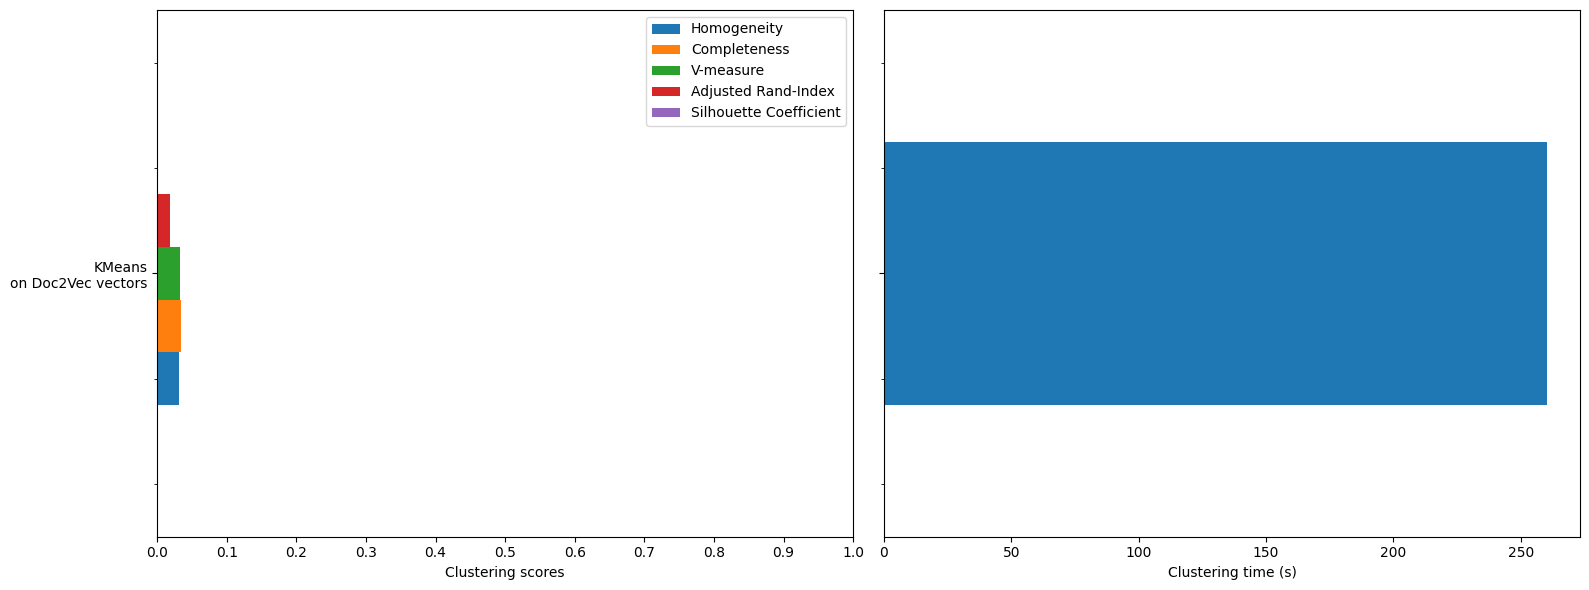

In [ ]:
#Call the `fit_and_evaluate` function to assess the performance of the KMeans algorithm
fit_and_evaluate(kmeans_three, embeddings_three, name="KMeans\non Doc2Vec vectors")

#Create subplots with two columns, shared y-axis, and specific figure size
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

#Create DataFrames from the evaluations and their standard deviations
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

#Plot clustering scores in the first subplot
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")
ax0.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
ax0.set_xticks(np.arange(0, 1.1, 0.1))

#Plot clustering time in the second subplot
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

#Adjust layout for better spacing
plt.tight_layout()


Now we visualize the comparison between number of documents in each cluster and actual documents in the categories

<Figure size 1200x800 with 0 Axes>

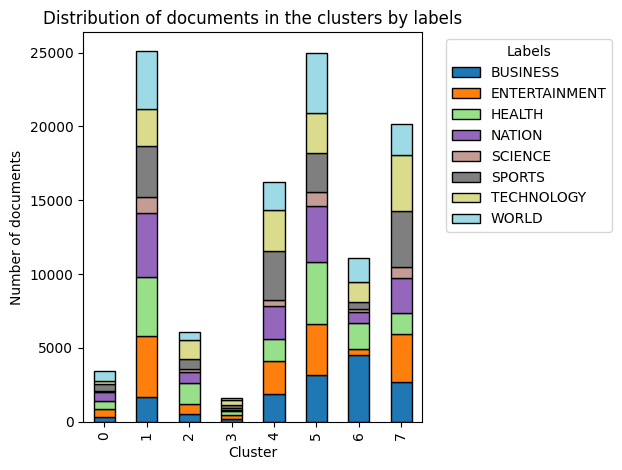

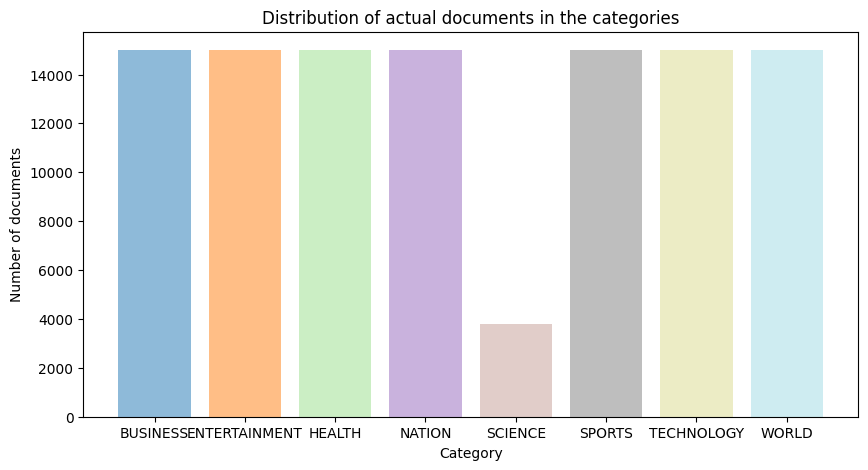


Distribution of documents in the clusters according to labels:
true_label  BUSINESS  ENTERTAINMENT  HEALTH  NATION  SCIENCE  SPORTS  \
cluster                                                                
0                346            500     567     634       64     443   
1               1665           4149    3974    4316     1145    3420   
2                509            677    1418     757      190     710   
3                207            289     206     115      116     231   
4               1852           2262    1482    2247      376    3314   
5               3164           3491    4164    3788      965    2640   
6               4557            404    1741     758      202     423   
7               2700           3228    1448    2385      716    3819   

true_label  TECHNOLOGY  WORLD  
cluster                        
0                  195    722  
1                 2532   3911  
2                 1246    593  
3                  300    175  
4                 2837 

In [ ]:
x_labels = news_three_df['Category']

#DataFrame with cluster labels and true labels
name_df = pd.DataFrame({'cluster': cluster_labels, 'true_label': x_labels})

#Cross-tabulation of clusters and true labels
x_cluster_label_counts = pd.crosstab(name_df['cluster'], name_df['true_label'])


#True labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(news_three_df['Category'])
category_names = label_encoder.classes_

#Format category names for the X-axis label
formatted_category_names = [name.replace(' ', '\n') for name in category_names]

#Calculate the number of documents in each category
category_sizes_three = np.bincount(y_labels)

#Create a DataFrame with cluster labels and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'true_label': y_labels})

#Create a cross-tabulation of clusters and true labels
cluster_label_counts = pd.crosstab(df['cluster'], df['true_label'])

#Define the colors to be used in both plots
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_labels))))

#Plotting
plt.figure(figsize=(12, 8))
cluster_label_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Distribution of documents in the clusters by labels')
plt.xlabel('Cluster')
plt.ylabel('Number of documents')
plt.legend(title='Labels', labels = category_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot the distribution of actual documents in the categories using the same colors
plt.figure(figsize=(10, 5))
plt.bar(range(len(category_sizes_three)), category_sizes_three, color=colors, alpha=0.5, label='Actual documents')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.title('Distribution of actual documents in the categories')
plt.xticks(range(len(category_sizes_three)), formatted_category_names)
plt.show()

#Output the numbers
print("\nDistribution of documents in the clusters according to labels:")
print(x_cluster_label_counts)

#Output of numbers
print("\nNumber of documents in each cluster:")
for cluster_id, cluster_size in enumerate(cluster_sizes_doc):
    print(f"Cluster {cluster_id}: {cluster_size}")

print("\nDistribution of actual documents in the categories:")
for category_id, category_size in enumerate(category_sizes_three):
    print(f"Category {category_id}: {category_size}")

Get the average cosine similarity for each category

In [ ]:
#True labels
categories = news_three_df['Category'].unique()
#Calculation of the average cosine similarity for each category.
avg_cos_sim_per_category = {}
for category in categories:
    #Extracting the indices of documents in the current category.
    indices = news_three_df[news_three_df['Category'] == category].index
    if len(indices) > 1:
        #Extracting the DM vectors of the documents in the current category
        category_doc = embeddings_three[indices]
        #Calculate the cosine similarity matrix for these documents.
        category_sim_matrix = cosine_similarity(category_doc)
        #Calculate the average cosine similarity (excluding diagonal values).
        sum_similarities = np.sum(category_sim_matrix) - len(indices)  #Sum of all values excluding diagonal elements.
        count_pairs = len(indices) * (len(indices) - 1)  #Number of pairs excluding diagonal elements.
        avg_cos_sim = sum_similarities / count_pairs
        avg_cos_sim_per_category[category] = avg_cos_sim
    else:
        avg_cos_sim_per_category[category] = 1.0  #If there is only one document, the similarity is 1.

#Output the average cosine similarity for each category.
for category, avg_cos_sim in avg_cos_sim_per_category.items():
    print(f"Average Cosine Similarity for {category}: {avg_cos_sim}")

Average Cosine Similarity for SCIENCE: 0.07639270169282174
Average Cosine Similarity for TECHNOLOGY: 0.05785403026868458
Average Cosine Similarity for HEALTH: 0.09839543080649821
Average Cosine Similarity for WORLD: 0.08445891059403961
Average Cosine Similarity for ENTERTAINMENT: 0.06924024712758628
Average Cosine Similarity for SPORTS: 0.06562198368780141
Average Cosine Similarity for BUSINESS: 0.09404749649976665
Average Cosine Similarity for NATION: 0.0682195879725315


Get the cosine siimilarity between categories

In [ ]:
#Get the unique categories
categories = news_three_df['Category'].unique()

#list for the results
results = []

#Pairs of consecutive categories
for i in range(0, len(categories) - 1, 2):  # Step size 2 to form pairs of two consecutive categories
    category1 = categories[i]
    category2 = categories[i + 1]

    #Extract the vectors of the documents in the first category
    indices1 = news_three_df[news_three_df['Category'] == category1].index
    category1_vector = embeddings_three[indices1]

    #Extract the documents in the second category
    indices2 = news_three_df[news_three_df['Category'] == category2].index
    category2_vector = embeddings_three[indices2]

    #Calculate the cosine similarity matrix between the documents of the two categories
    similarity_matrix = cosine_similarity(category1_vector, category2_vector)

    #Calculate the average cosine similarity value between the two categories
    avg_cos_sim_between_categories = np.mean(similarity_matrix)

    #Save the result
    results.append((category1, category2, avg_cos_sim_between_categories))

#Output the average cosine similarity for each pair of consecutive categories
for category1, category2, avg_cos_sim in results:
    print(f"Average Cosine Similarity between {category1} and {category2}: {avg_cos_sim}")

#If the number of categories is odd, the last category will not be processed
if len(categories) % 2 != 0:
    print(f"Warning: The number of categories is odd, the last category '{categories[-1]}' has no pair.")


Average Cosine Similarity between SCIENCE and TECHNOLOGY: 0.040445152670145035
Average Cosine Similarity between HEALTH and WORLD: 0.07259855419397354
Average Cosine Similarity between ENTERTAINMENT and SPORTS: 0.046812646090984344
Average Cosine Similarity between BUSINESS and NATION: 0.05533779039978981


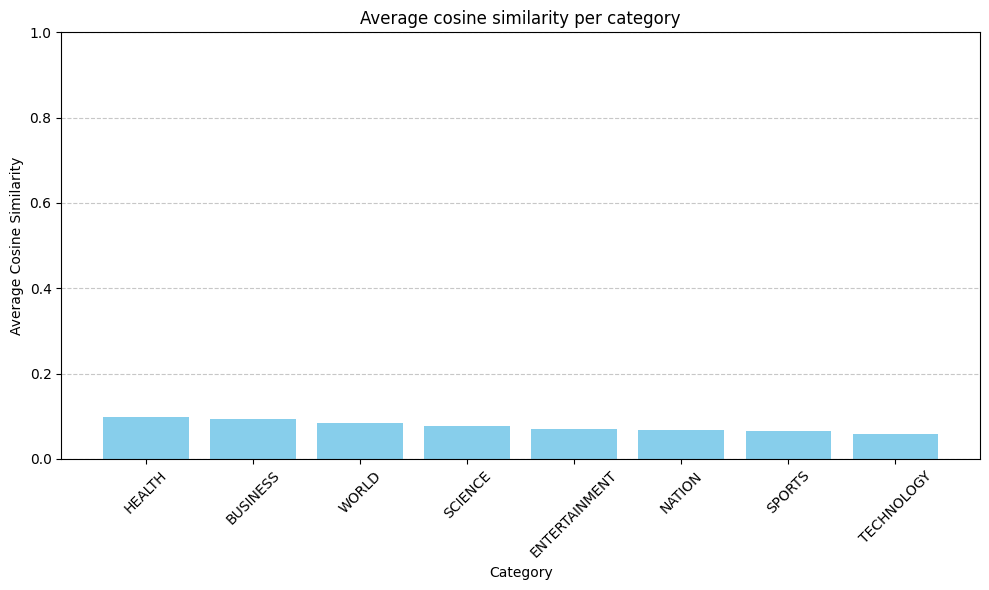

In [ ]:
#Sort the categories by average cosine similarity
sorted_categories = sorted(avg_cos_sim_per_category.keys(), key=lambda x: avg_cos_sim_per_category[x], reverse=True)
sorted_avg_cos_sim = [avg_cos_sim_per_category[cat] for cat in sorted_categories]

#Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_categories, sorted_avg_cos_sim, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average cosine similarity per category')
plt.xticks(rotation=45)
plt.ylim(0, 1)  #Limit y-axis scale to 0 to 1 (since Cosine Similarity is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show chart
plt.show()

Now we want to show the top ten documents and terms for each cluster based on the cosine similarity.

In [ ]:
#Number of top documents you want to display
num_top_documents = 10

#Empty list to store the most important documents for each cluster
top_documents_per_cluster = []

#Iterate over each cluster
for cluster_id in range(true_k_three):

    #Filter the indexes of documents associated with this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    #Calculate the cosine similarity between the cluster center and all documents
    cluster_center = kmeans_three.cluster_centers_[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, embeddings_three)[0]

    #Sort the documents according to their similarity and get the indices
    sorted_document_indices = cluster_indices[np.argsort(similarities[cluster_indices])[::-1]]

    #Select the first num_top_documents documents
    top_document_indices = sorted_document_indices[:num_top_documents]

    #Store the indexes of the top documents for this cluster
    top_documents_per_cluster.append(top_document_indices)

Here we create a heatmap which visually represents the top categories for each cluster based on the cosine similarity. The documents are sorted in descending order according to their similarity to the cluster center.

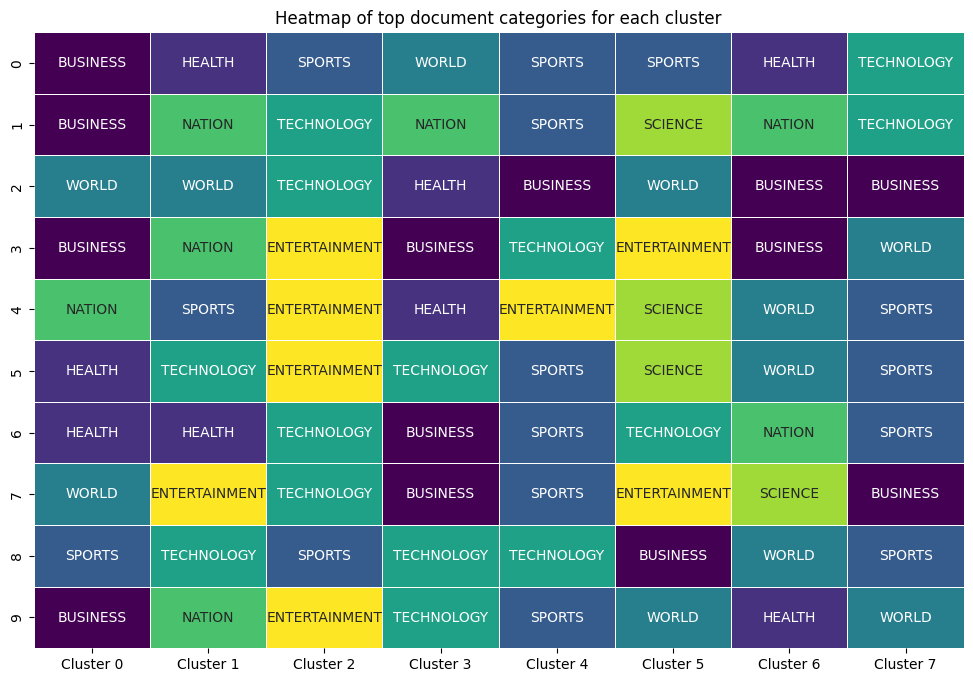

In [ ]:
#Create a heatmap of the top document categories for each cluster
heatmap_data = []
for cluster_id, top_document_indices in enumerate(top_documents_per_cluster):
    top_categories = news_three_df.iloc[top_document_indices]['Category'].values
    formatted_categories = ['\n'.join(category.split()) for category in top_categories]
    heatmap_data.append(formatted_categories)

#Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Cluster {i}' for i in range(true_k)])
heatmap_df = heatmap_df.T  # Transpose for better visualization
heatmap_df = heatmap_df.dropna()

#Convert categories to numerical values for heatmap coloring
category_to_num = {category: num for num, category in enumerate(heatmap_df.stack().unique())}
heatmap_numeric = heatmap_df.applymap(lambda x: category_to_num[x])

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_numeric,
    annot=heatmap_df,
    fmt='',
    cmap='viridis',
    cbar=False,
    linewidths=.5
)
plt.title("Heatmap of top document categories for each cluster")
plt.show()


# **Sources**

The datasets,code, different methods and explanations are from these sources:

* https://www.kaggle.com/datasets/rafsunahmad/classify-news-into-category
* https://www.kaggle.com/datasets/setseries/news-category-dataset
* https://www.kaggle.com/datasets/kotartemiy/topic-labeled-news-dataset
* https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
*https://www.learndatasci.com/glossary/cosine-similarity/
*https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
*https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
* ChatGPT to generate code and text
*  Q. Le and T. Mikolov, “Distributed representations of sentences and documents,”
31st International Conference on Machine Learning, ICML 2014, vol. 4, 05 2014.
